## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## Optunaによるハイパーパラメーターチューニング

In [2]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted 

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074


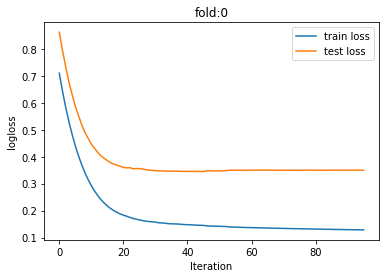

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997


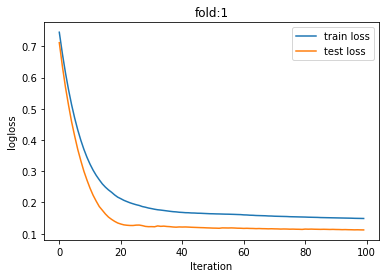

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503


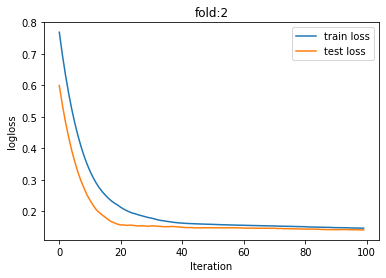

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725


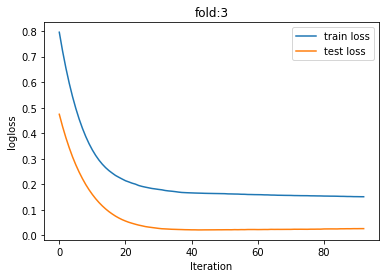

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033


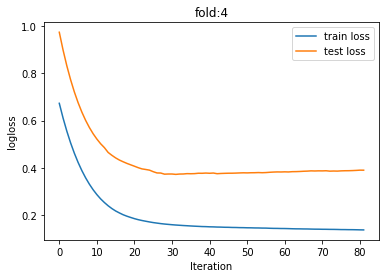

RMSE: [0.3450743092184951, 0.1119966357028154, 0.141502625741997, 0.021772539884382606, 0.37303280298429786]
RMSE: 0.1986757827063976


In [6]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},           # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

### optuna.integration.lightgbm によるハイパーパラメーター調整実施



[I 2021-12-27 16:20:23,208] A new study created in memory with name: no-name-07ba7d79-8fef-4da7-82d8-b888c408d729
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  14%|######4                                      | 1/7 [00:00<00:01,  3.68it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.148039	Test's rmse: 0.34123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  29%|############8                                | 2/7 [00:00<00:01,  3.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119969	Test's rmse: 0.363198
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  43%|###################2                         | 3/7 [00:00<00:01,  3.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112125	Test's rmse: 0.351581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  57%|#########################7                   | 4/7 [00:01<00:00,  3.61it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153983	Test's rmse: 0.34335
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  71%|################################1            | 5/7 [00:01<00:00,  3.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107351	Test's rmse: 0.353489
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  86%|######################################5      | 6/7 [00:01<00:00,  3.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.105091	Test's rmse: 0.352722
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230: 100%|#############################################| 7/7 [00:01<00:00,  3.78it/s]


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074


num_leaves, val_score: 0.341230:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:   5%|##5                                               | 1/20 [00:01<00:22,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.118865	Test's rmse: 0.345978
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  10%|#####                                             | 2/20 [00:01<00:14,  1.27it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.145488	Test's rmse: 0.347389
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  15%|#######5                                          | 3/20 [00:02<00:11,  1.42it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.138024	Test's rmse: 0.344908
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  20%|##########                                        | 4/20 [00:03<00:11,  1.34it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.142346	Test's rmse: 0.345172
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.341230:  25%|############5                                     | 5/20 [00:04<00:13,  1.09it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.142861	Test's rmse: 0.347508
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340568:  30%|###############                                   | 6/20 [00:04<00:09,  1.46it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.141086	Test's rmse: 0.340568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340568:  35%|#################5                                | 7/20 [00:05<00:10,  1.25it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.142551	Test's rmse: 0.347019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340568:  40%|####################                              | 8/20 [00:05<00:07,  1.58it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.147963	Test's rmse: 0.344921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340568:  45%|######################5                           | 9/20 [00:06<00:06,  1.64it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.142351	Test's rmse: 0.34794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.340568:  50%|########################5                        | 10/20 [00:07<00:07,  1.28it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.142715	Test's rmse: 0.346822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	Train's rmse: 0.150586	Test's rmse: 0.336448


num_leaves, val_score: 0.336448:  60%|#############################4                   | 12/20 [00:07<00:03,  2.24it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	Train's rmse: 0.151205	Test's rmse: 0.337885
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best itera

num_leaves, val_score: 0.328631:  65%|###############################8                 | 13/20 [00:07<00:03,  2.24it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631:  75%|####################################7            | 15/20 [00:08<00:01,  3.46it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.150048	Test's rmse: 0.346476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174981	Test's rmse: 0.328631
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
T

num_leaves, val_score: 0.328631:  80%|#######################################2         | 16/20 [00:08<00:01,  3.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1224	Test's rmse: 0.343369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631:  85%|#########################################6       | 17/20 [00:09<00:01,  2.38it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.142323	Test's rmse: 0.345031
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631:  90%|############################################1    | 18/20 [00:09<00:00,  2.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121407	Test's rmse: 0.34295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631:  95%|##############################################5  | 19/20 [00:10<00:00,  2.57it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.1426	Test's rmse: 0.346782
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631: 100%|#################################################| 20/20 [00:10<00:00,  1.91it/s]


Early stopping, best iteration is:
[39]	Train's rmse: 0.148039	Test's rmse: 0.34123


bagging, val_score: 0.328631:  10%|#####3                                               | 1/10 [00:00<00:00,  9.72it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168802	Test's rmse: 0.32973
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.328631:  20%|##########6                                          | 2/10 [00:00<00:00,  9.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165382	Test's rmse: 0.331837


bagging, val_score: 0.328631:  30%|###############9                                     | 3/10 [00:00<00:00,  9.60it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173936	Test's rmse: 0.334223
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stoppi

bagging, val_score: 0.328631:  50%|##########################5                          | 5/10 [00:00<00:00,  9.50it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168988	Test's rmse: 0.328986
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validat

bagging, val_score: 0.328631:  70%|#####################################                | 7/10 [00:00<00:00,  8.59it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169005	Test's rmse: 0.332618
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validat

bagging, val_score: 0.328631:  90%|###############################################7     | 9/10 [00:01<00:00,  8.76it/s]


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.181174	Test's rmse: 0.33421
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validati

feature_fraction_stage2, val_score: 0.327451:  17%|######3                               | 1/6 [00:00<00:00,  8.23it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16744	Test's rmse: 0.327451
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172675	Test's rmse: 

feature_fraction_stage2, val_score: 0.327451:  50%|###################                   | 3/6 [00:00<00:00,  8.87it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174118	Test's rmse: 0.329209
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stoppi

feature_fraction_stage2, val_score: 0.327451: 100%|######################################| 6/6 [00:00<00:00,  9.48it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174981	Test's rmse: 0.328631
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validat

[I 2021-12-27 16:20:37,373] Trial 42 finished with value: 0.3292093522750144 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.3274514860606093.
regularization_factors, val_score: 0.325121:   5%|#9                                    | 1/20 [00:00<00:01,  9.80it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16679	Test's rmse: 0.325121
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validati

regularization_factors, val_score: 0.325121:  15%|#####7                                | 3/20 [00:00<00:02,  8.11it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16744	Test's rmse: 0.327451
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validati

regularization_factors, val_score: 0.325121:  25%|#########5                            | 5/20 [00:00<00:01,  8.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16744	Test's rmse: 0.327451
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16744	Test's rmse: 0.327451
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from scor

regularization_factors, val_score: 0.325121:  35%|#############3                        | 7/20 [00:00<00:01,  8.29it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16744	Test's rmse: 0.327452
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16744	Test's rmse: 0.327451


regularization_factors, val_score: 0.322952:  40%|###############2                      | 8/20 [00:00<00:01,  8.57it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16549	Test's rmse: 0.322952
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validati

regularization_factors, val_score: 0.322952:  50%|##################5                  | 10/20 [00:01<00:01,  8.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167441	Test's rmse: 0.327452
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16744	Test's rmse: 0.327451
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, numbe

regularization_factors, val_score: 0.322952:  60%|######################2              | 12/20 [00:01<00:00,  8.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172091	Test's rmse: 0.329154
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166313	Test's rmse: 0.326384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.322952:  65%|########################             | 13/20 [00:01<00:00,  7.91it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166806	Test's rmse: 0.325819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.322952:  75%|###########################7         | 15/20 [00:01<00:00,  8.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173119	Test's rmse: 0.32896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16736	Test's rmse: 0.327065
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.322952:  80%|#############################6       | 16/20 [00:01<00:00,  7.82it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167441	Test's rmse: 0.327452
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.322628:  90%|#################################3   | 18/20 [00:02<00:00,  7.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167795	Test's rmse: 0.326833
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162345	Test's rmse: 0.322628
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.322628:  95%|###################################1 | 19/20 [00:02<00:00,  7.68it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167581	Test's rmse: 0.325312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167958	Test's rmse: 0.327011


min_data_in_leaf, val_score: 0.322628:  20%|#########                                    | 1/5 [00:00<00:00,  8.00it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150148	Test's rmse: 0.331263
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161525	Test's rmse:

min_data_in_leaf, val_score: 0.322628:  80%|####################################         | 4/5 [00:00<00:00,  9.33it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166022	Test's rmse: 0.322636
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validat

[I 2021-12-27 16:20:40,312] Trial 66 finished with value: 0.38061705462333517 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.32263616696569575.
min_data_in_leaf, val_score: 0.322628: 100%|#############################################| 5/5 [00:00<00:00,  8.80it/s]


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.263675	Test's rmse: 0.410095


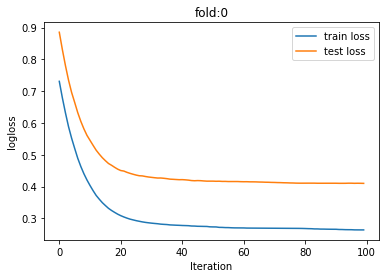

[I 2021-12-27 16:20:40,622] A new study created in memory with name: no-name-192fd3f1-19cd-43f4-901e-78a19fe30427
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  14%|######4                                      | 1/7 [00:00<00:01,  3.70it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133798	Test's rmse: 0.103132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  29%|############8                                | 2/7 [00:00<00:01,  3.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131693	Test's rmse: 0.122502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  43%|###################2                         | 3/7 [00:00<00:01,  3.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  57%|#########################7                   | 4/7 [00:01<00:00,  3.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144067	Test's rmse: 0.105227
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  71%|################################1            | 5/7 [00:01<00:00,  3.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136538	Test's rmse: 0.131841
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  86%|######################################5      | 6/7 [00:01<00:00,  3.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134845	Test's rmse: 0.108049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132: 100%|#############################################| 7/7 [00:02<00:00,  3.46it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130288	Test's rmse: 0.11942


num_leaves, val_score: 0.103132:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:   5%|##5                                               | 1/20 [00:00<00:06,  2.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137776	Test's rmse: 0.10567
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.103132:  10%|#####                                             | 2/20 [00:01<00:14,  1.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13701	Test's rmse: 0.116295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  15%|#######5                                          | 3/20 [00:02<00:11,  1.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136798	Test's rmse: 0.1095
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  20%|##########                                        | 4/20 [00:02<00:09,  1.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136747	Test's rmse: 0.109503
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.103132:  25%|############5                                     | 5/20 [00:03<00:11,  1.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137173	Test's rmse: 0.115503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  30%|###############                                   | 6/20 [00:04<00:10,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136528	Test's rmse: 0.113429
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  35%|#################5                                | 7/20 [00:04<00:08,  1.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138735	Test's rmse: 0.10702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  40%|####################                              | 8/20 [00:05<00:08,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134788	Test's rmse: 0.112407
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  45%|######################5                           | 9/20 [00:06<00:08,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139012	Test's rmse: 0.114625
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  50%|########################5                        | 10/20 [00:07<00:08,  1.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137024	Test's rmse: 0.115695
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151599	Test's rmse: 0.104847


num_leaves, val_score: 0.103132:  60%|#############################4                   | 12/20 [00:07<00:03,  2.05it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.202714	Test's rmse: 0.117889
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  65%|###############################8                 | 13/20 [00:08<00:02,  2.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135522	Test's rmse: 0.106233
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  70%|##################################3              | 14/20 [00:08<00:02,  2.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136667	Test's rmse: 0.105286
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.101914:  75%|####################################7            | 15/20 [00:08<00:01,  2.75it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138896	Test's rmse: 0.101914
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.101914:  80%|#######################################2         | 16/20 [00:09<00:01,  3.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139447	Test's rmse: 0.102368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.101914:  85%|#########################################6       | 17/20 [00:09<00:01,  2.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137256	Test's rmse: 0.113961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.101914:  90%|############################################1    | 18/20 [00:10<00:00,  2.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137381	Test's rmse: 0.108182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.101914:  95%|##############################################5  | 19/20 [00:10<00:00,  2.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133798	Test's rmse: 0.103132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.101914: 100%|#################################################| 20/20 [00:10<00:00,  1.83it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136906	Test's rmse: 0.107963


bagging, val_score: 0.101914:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  10%|#####3                                               | 1/10 [00:00<00:02,  3.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161851	Test's rmse: 0.114242
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  20%|##########6                                          | 2/10 [00:00<00:02,  3.32it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.183919	Test's rmse: 0.121803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  30%|###############9                                     | 3/10 [00:00<00:02,  3.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152838	Test's rmse: 0.117021
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  40%|#####################2                               | 4/10 [00:01<00:01,  3.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17009	Test's rmse: 0.120545
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  50%|##########################5                          | 5/10 [00:01<00:01,  2.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150503	Test's rmse: 0.119671
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  60%|###############################8                     | 6/10 [00:01<00:01,  2.88it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182071	Test's rmse: 0.120187
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  70%|#####################################                | 7/10 [00:02<00:01,  2.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178963	Test's rmse: 0.12322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  80%|##########################################4          | 8/10 [00:02<00:00,  2.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173951	Test's rmse: 0.113577
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914:  90%|###############################################7     | 9/10 [00:02<00:00,  3.11it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.183378	Test's rmse: 0.113078
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.101914: 100%|####################################################| 10/10 [00:03<00:00,  3.12it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178942	Test's rmse: 0.119717


feature_fraction_stage2, val_score: 0.101914:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.101914:  17%|######3                               | 1/6 [00:00<00:01,  3.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134807	Test's rmse: 0.107757
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.101914:  33%|############6                         | 2/6 [00:00<00:01,  3.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137358	Test's rmse: 0.107206
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.101914:  50%|###################                   | 3/6 [00:00<00:00,  3.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14095	Test's rmse: 0.10532
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.101914:  67%|#########################3            | 4/6 [00:01<00:00,  2.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138896	Test's rmse: 0.101914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.101914:  83%|###############################6      | 5/6 [00:01<00:00,  2.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14095	Test's rmse: 0.10532
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.101914: 100%|######################################| 6/6 [00:01<00:00,  3.15it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137358	Test's rmse: 0.107206


regularization_factors, val_score: 0.101914:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101914:   5%|#9                                    | 1/20 [00:00<00:05,  3.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136301	Test's rmse: 0.105749
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101914:  10%|###8                                  | 2/20 [00:00<00:05,  3.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138774	Test's rmse: 0.102091
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101914:  15%|#####7                                | 3/20 [00:00<00:05,  3.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135285	Test's rmse: 0.102254
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101914:  20%|#######6                              | 4/20 [00:01<00:05,  3.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138774	Test's rmse: 0.102091
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101914:  25%|#########5                            | 5/20 [00:01<00:04,  3.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137916	Test's rmse: 0.104613
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101914:  30%|###########4                          | 6/20 [00:01<00:04,  2.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138774	Test's rmse: 0.102091
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101914:  35%|#############3                        | 7/20 [00:02<00:04,  2.89it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139969	Test's rmse: 0.107544
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.101914:  40%|###############2                      | 8/20 [00:02<00:04,  2.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141619	Test's rmse: 0.112811
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447:  45%|#################1                    | 9/20 [00:03<00:03,  2.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138027	Test's rmse: 0.101447
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.101447:  50%|##################5                  | 10/20 [00:03<00:03,  2.76it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13911	Test's rmse: 0.106357
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.101447:  55%|####################3                | 11/20 [00:03<00:02,  3.02it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.101447:  60%|######################2              | 12/20 [00:04<00:03,  2.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138896	Test's rmse: 0.101914
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447:  65%|########################             | 13/20 [00:04<00:02,  2.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138896	Test's rmse: 0.101914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447:  70%|#########################9           | 14/20 [00:05<00:02,  2.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138896	Test's rmse: 0.101914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447:  75%|###########################7         | 15/20 [00:05<00:02,  2.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138774	Test's rmse: 0.102091
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447:  80%|#############################6       | 16/20 [00:05<00:01,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138896	Test's rmse: 0.101914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447:  85%|###############################4     | 17/20 [00:06<00:01,  2.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138774	Test's rmse: 0.102091
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447:  90%|#################################3   | 18/20 [00:06<00:00,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138224	Test's rmse: 0.105374
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.101447:  95%|###################################1 | 19/20 [00:07<00:00,  2.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:21:05,758] Trial 61 finished with value: 0.1121421926077409 and parameters: {'lambda_l1': 3.617109297656081, 'lambda_l2': 2.1457568431527286e-07}. Best is trial 51 with value: 0.10144739172351346.
regularization_factors, val_score: 0.101447:  95%|###################################1 | 19/20 [00:07<00:00,  2.52it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.101447: 100%|#####################################| 20/20 [00:07<00:00,  2.64it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138896	Test's rmse: 0.101914


min_data_in_leaf, val_score: 0.101447:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.101447:  20%|#########                                    | 1/5 [00:00<00:02,  1.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0680976	Test's rmse: 0.1187
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.101447:  40%|##################                           | 2/5 [00:00<00:01,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.239282	Test's rmse: 0.187077
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.101447:  60%|###########################                  | 3/5 [00:01<00:00,  2.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0269096	Test's rmse: 0.129314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.101447:  80%|####################################         | 4/5 [00:01<00:00,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15918	Test's rmse: 0.115078
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.101447: 100%|#############################################| 5/5 [00:01<00:00,  2.54it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.329682	Test's rmse: 0.232316


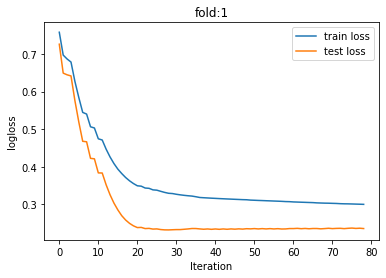

[I 2021-12-27 16:21:08,438] A new study created in memory with name: no-name-adeacb69-2200-4e1a-9537-2913216e4194
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.169026:  14%|######4                                      | 1/7 [00:00<00:01,  3.89it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134967	Test's rmse: 0.169026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.149363:  29%|############8                                | 2/7 [00:00<00:01,  3.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12905	Test's rmse: 0.149363
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139906:  43%|###################2                         | 3/7 [00:00<00:01,  3.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14443	Test's rmse: 0.139906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139906:  57%|#########################7                   | 4/7 [00:01<00:00,  4.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155903	Test's rmse: 0.140315
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129464	Test's rmse: 0.160576


feature_fraction, val_score: 0.139906:  71%|################################1            | 5/7 [00:01<00:00,  4.29it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503


feature_fraction, val_score: 0.139906: 100%|#############################################| 7/7 [00:01<00:00,  4.49it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128939	Test's rmse: 0.159312


[I 2021-12-27 16:21:10,106] Trial 6 finished with value: 0.1593121386019105 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.1399063359860016.
num_leaves, val_score: 0.139906:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:   5%|##5                                               | 1/20 [00:00<00:12,  1.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145545	Test's rmse: 0.145946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  15%|#######5                                          | 3/20 [00:01<00:05,  2.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143997	Test's rmse: 0.14312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196966	Test's rmse: 0.164558
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 5

num_leaves, val_score: 0.139906:  20%|##########                                        | 4/20 [00:02<00:09,  1.68it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144101	Test's rmse: 0.145637
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  25%|############5                                     | 5/20 [00:02<00:08,  1.77it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143325	Test's rmse: 0.140712
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139645:  30%|###############                                   | 6/20 [00:03<00:07,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143468	Test's rmse: 0.139645
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139645:  35%|#################5                                | 7/20 [00:03<00:07,  1.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146713	Test's rmse: 0.144072
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139645:  40%|####################                              | 8/20 [00:04<00:05,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139921	Test's rmse: 0.140956
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139645:  45%|######################5                           | 9/20 [00:04<00:05,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143997	Test's rmse: 0.14312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139645:  50%|########################5                        | 10/20 [00:05<00:06,  1.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142824	Test's rmse: 0.14361
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139645:  55%|##########################9                      | 11/20 [00:06<00:06,  1.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138981	Test's rmse: 0.141184
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139645:  60%|#############################4                   | 12/20 [00:06<00:04,  1.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145515	Test's rmse: 0.141024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139226:  65%|###############################8                 | 13/20 [00:07<00:03,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137652	Test's rmse: 0.139226
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138997:  75%|####################################7            | 15/20 [00:07<00:01,  3.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137575	Test's rmse: 0.138997
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161555	Test's rmse: 0.15101
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, numbe

num_leaves, val_score: 0.138997:  80%|#######################################2         | 16/20 [00:07<00:01,  3.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139921	Test's rmse: 0.140956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138997:  85%|#########################################6       | 17/20 [00:08<00:00,  3.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143788	Test's rmse: 0.141567
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138997:  90%|############################################1    | 18/20 [00:09<00:01,  1.77it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144507	Test's rmse: 0.143625
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  95%|##############################################5  | 19/20 [00:09<00:00,  2.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14426	Test's rmse: 0.138532
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14334	Test's rmse: 0.140903


bagging, val_score: 0.138532:  10%|#####3                                               | 1/10 [00:00<00:01,  5.35it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175456	Test's rmse: 0.154301
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.138532:  20%|##########6                                          | 2/10 [00:00<00:01,  5.35it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168779	Test's rmse: 0.154006
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.138532:  30%|###############9                                     | 3/10 [00:00<00:01,  5.47it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170643	Test's rmse: 0.146364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112


bagging, val_score: 0.138532:  40%|#####################2                               | 4/10 [00:00<00:01,  5.23it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17976	Test's rmse: 0.158892


bagging, val_score: 0.138532:  50%|##########################5                          | 5/10 [00:00<00:00,  5.15it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180179	Test's rmse: 0.160498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.138532:  60%|###############################8                     | 6/10 [00:01<00:00,  5.13it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149135	Test's rmse: 0.146383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.138532:  70%|#####################################                | 7/10 [00:01<00:00,  5.12it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15887	Test's rmse: 0.147989
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.138532:  80%|##########################################4          | 8/10 [00:01<00:00,  5.44it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180715	Test's rmse: 0.163302
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138532:  90%|###############################################7     | 9/10 [00:01<00:00,  5.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168998	Test's rmse: 0.152646
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143884	Test's rmse: 0.142381


feature_fraction_stage2, val_score: 0.138532:  17%|######3                               | 1/6 [00:00<00:00,  5.99it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14426	Test's rmse: 0.138532
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112


feature_fraction_stage2, val_score: 0.138532:  33%|############6                         | 2/6 [00:00<00:00,  6.00it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128812	Test's rmse: 0.146218
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.138532:  50%|###################                   | 3/6 [00:00<00:00,  5.76it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140806	Test's rmse: 0.140768
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140806	Test's rmse: 0.140768


feature_fraction_stage2, val_score: 0.136961:  83%|###############################6      | 5/6 [00:00<00:00,  5.29it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


feature_fraction_stage2, val_score: 0.136961: 100%|######################################| 6/6 [00:01<00:00,  5.38it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961



regularization_factors, val_score: 0.136961:   5%|#9                                    | 1/20 [00:00<00:03,  4.78it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


[I 2021-12-27 16:21:22,977] Trial 43 finished with value: 0.13696094662703157 and parameters: {'lambda_l1': 1.0296645206178409e-07, 'lambda_l2': 0.00011602551513388137}. Best is trial 43 with value: 0.13696094662703157.
regularization_factors, val_score: 0.136961:  10%|###8                                  | 2/20 [00:00<00:03,  4.69it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136006	Test's rmse: 0.136962
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.136961:  15%|#####7                                | 3/20 [00:00<00:03,  4.85it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138549	Test's rmse: 0.138738
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13321	Test's rmse: 0.139333


regularization_factors, val_score: 0.136961:  25%|#########5                            | 5/20 [00:01<00:03,  4.82it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.136961:  30%|###########4                          | 6/20 [00:01<00:02,  5.11it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.136961:  35%|#############3                        | 7/20 [00:01<00:02,  5.39it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133285	Test's rmse: 0.13938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.136961:  40%|###############2                      | 8/20 [00:01<00:02,  5.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136007	Test's rmse: 0.136962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13923	Test's rmse: 0.1461


regularization_factors, val_score: 0.136961:  50%|##################5                  | 10/20 [00:01<00:01,  5.58it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131515	Test's rmse: 0.143805


regularization_factors, val_score: 0.136961:  55%|####################3                | 11/20 [00:02<00:01,  5.06it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


[I 2021-12-27 16:21:24,910] Trial 53 finished with value: 0.1369608791675667 and parameters: {'lambda_l1': 1.802594471604389e-08, 'lambda_l2': 1.2761749722977749e-08}. Best is trial 53 with value: 0.1369608791675667.
regularization_factors, val_score: 0.136961:  60%|######################2              | 12/20 [00:02<00:01,  4.95it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


regularization_factors, val_score: 0.136961:  65%|########################             | 13/20 [00:02<00:01,  4.88it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138545	Test's rmse: 0.138737


regularization_factors, val_score: 0.136961:  70%|#########################9           | 14/20 [00:02<00:01,  4.73it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


regularization_factors, val_score: 0.136961:  75%|###########################7         | 15/20 [00:03<00:01,  4.69it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138546	Test's rmse: 0.138737


regularization_factors, val_score: 0.136961:  80%|#############################6       | 16/20 [00:03<00:00,  4.68it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


regularization_factors, val_score: 0.136961:  85%|###############################4     | 17/20 [00:03<00:00,  4.72it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138164	Test's rmse: 0.138817


regularization_factors, val_score: 0.136961:  90%|#################################3   | 18/20 [00:03<00:00,  4.90it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.136961:  95%|###################################1 | 19/20 [00:03<00:00,  4.92it/s]

[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


regularization_factors, val_score: 0.136961: 100%|#####################################| 20/20 [00:04<00:00,  4.93it/s]


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


min_data_in_leaf, val_score: 0.136961:  20%|#########                                    | 1/5 [00:00<00:00,  6.25it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0402285	Test's rmse: 0.154917
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.136961:  40%|##################                           | 2/5 [00:00<00:00,  6.15it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.117658	Test's rmse: 0.154824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.284769	Test's rmse: 0.195085


min_data_in_leaf, val_score: 0.136961:  60%|###########################                  | 3/5 [00:00<00:00,  5.73it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147657	Test's rmse: 0.151099


min_data_in_leaf, val_score: 0.136961:  80%|####################################         | 4/5 [00:00<00:00,  5.20it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.136961: 100%|#############################################| 5/5 [00:00<00:00,  5.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.224713	Test's rmse: 0.174862


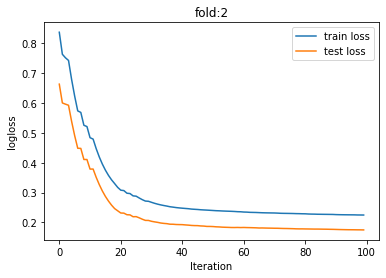

[I 2021-12-27 16:21:27,980] A new study created in memory with name: no-name-3dc4259e-feec-4f79-a1fe-81b09c480922
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.093056:  14%|######4                                      | 1/7 [00:00<00:01,  3.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136853	Test's rmse: 0.0930559
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.090146:  29%|############8                                | 2/7 [00:00<00:01,  3.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126647	Test's rmse: 0.0901461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.083066:  43%|###################2                         | 3/7 [00:00<00:01,  3.32it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133355	Test's rmse: 0.0830657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773:  57%|#########################7                   | 4/7 [00:01<00:00,  3.41it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773:  71%|################################1            | 5/7 [00:01<00:00,  3.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144156	Test's rmse: 0.0541509
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773:  86%|######################################5      | 6/7 [00:01<00:00,  2.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150344	Test's rmse: 0.0401701
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773: 100%|#############################################| 7/7 [00:02<00:00,  3.03it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129613	Test's rmse: 0.0803229


num_leaves, val_score: 0.021773:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021677:   5%|##5                                               | 1/20 [00:00<00:14,  1.29it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.167365	Test's rmse: 0.0219079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	Train's rmse: 0.16391	Test's rmse: 0.0216766


num_leaves, val_score: 0.021677:  15%|#######5                                          | 3/20 [00:01<00:04,  3.59it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.192896	Test's rmse: 0.0403581
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until valida

num_leaves, val_score: 0.021677:  20%|##########                                        | 4/20 [00:02<00:09,  1.77it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165305	Test's rmse: 0.0221488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.021677:  25%|############5                                     | 5/20 [00:03<00:12,  1.17it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221596
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021677:  35%|#################5                                | 7/20 [00:04<00:07,  1.65it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165307	Test's rmse: 0.0221469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157789	Test's rmse: 0.0239562
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021677:  40%|####################                              | 8/20 [00:04<00:07,  1.69it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.167403	Test's rmse: 0.0222628
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021677:  45%|######################5                           | 9/20 [00:05<00:06,  1.60it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165361	Test's rmse: 0.0219749
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021605:  50%|########################5                        | 10/20 [00:05<00:05,  1.83it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165782	Test's rmse: 0.0216049
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021605:  55%|##########################9                      | 11/20 [00:06<00:04,  1.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147646	Test's rmse: 0.0303376
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  60%|#############################4                   | 12/20 [00:06<00:03,  2.14it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.164443	Test's rmse: 0.0211783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  65%|###############################8                 | 13/20 [00:07<00:03,  2.20it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.161886	Test's rmse: 0.0225058
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  70%|##################################3              | 14/20 [00:07<00:02,  2.28it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165788	Test's rmse: 0.0216049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  75%|####################################7            | 15/20 [00:08<00:02,  2.18it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165386	Test's rmse: 0.0219178
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  80%|#######################################2         | 16/20 [00:08<00:02,  1.76it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.16481	Test's rmse: 0.0221297
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  85%|#########################################6       | 17/20 [00:09<00:01,  2.01it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166059	Test's rmse: 0.0217695
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  90%|############################################1    | 18/20 [00:10<00:01,  1.73it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.164186	Test's rmse: 0.0220722
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178:  95%|##############################################5  | 19/20 [00:10<00:00,  2.09it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.165566	Test's rmse: 0.0220105
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021178: 100%|#################################################| 20/20 [00:10<00:00,  1.86it/s]


Early stopping, best iteration is:
[42]	Train's rmse: 0.167427	Test's rmse: 0.0218835


bagging, val_score: 0.021178:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  10%|#####3                                               | 1/10 [00:00<00:03,  2.88it/s]

Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.173757	Test's rmse: 0.0266324
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  20%|##########6                                          | 2/10 [00:00<00:02,  3.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168857	Test's rmse: 0.0274326
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  30%|###############9                                     | 3/10 [00:00<00:02,  3.24it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.184001	Test's rmse: 0.036324
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  40%|#####################2                               | 4/10 [00:01<00:01,  3.14it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.199006	Test's rmse: 0.0328413
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  50%|##########################5                          | 5/10 [00:01<00:01,  3.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161506	Test's rmse: 0.0277742
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  60%|###############################8                     | 6/10 [00:01<00:01,  3.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149834	Test's rmse: 0.0313301
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  70%|#####################################                | 7/10 [00:02<00:01,  3.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165287	Test's rmse: 0.0311535
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  80%|##########################################4          | 8/10 [00:02<00:00,  3.06it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165867	Test's rmse: 0.0227938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178:  90%|###############################################7     | 9/10 [00:02<00:00,  3.14it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.202208	Test's rmse: 0.0318138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.021178: 100%|####################################################| 10/10 [00:03<00:00,  3.12it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17061	Test's rmse: 0.0339171


feature_fraction_stage2, val_score: 0.021178:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.021178:  33%|############6                         | 1/3 [00:00<00:00,  3.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147733	Test's rmse: 0.0466329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.021178:  67%|#########################3            | 2/3 [00:00<00:00,  3.24it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.164443	Test's rmse: 0.0211783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.021178: 100%|######################################| 3/3 [00:00<00:00,  3.13it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147238	Test's rmse: 0.046753


regularization_factors, val_score: 0.021178:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

regularization_factors, val_score: 0.021005:   5%|#9                                    | 1/20 [00:00<00:06,  2.85it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020732:  10%|###8                                  | 2/20 [00:00<00:06,  2.76it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.163892	Test's rmse: 0.0207316
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.020732:  15%|#####7                                | 3/20 [00:00<00:05,  3.37it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.020306:  20%|#######6                              | 4/20 [00:01<00:05,  3.17it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

regularization_factors, val_score: 0.020306:  25%|#########5                            | 5/20 [00:01<00:04,  3.55it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143616	Test's rmse: 0.0252911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't im

regularization_factors, val_score: 0.020306:  30%|###########4                          | 6/20 [00:01<00:04,  3.18it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.164443	Test's rmse: 0.0211783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  35%|#############3                        | 7/20 [00:02<00:04,  3.07it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.165645	Test's rmse: 0.0209697
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  40%|###############2                      | 8/20 [00:02<00:04,  2.99it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.164104	Test's rmse: 0.021467
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  45%|#################1                    | 9/20 [00:02<00:03,  2.94it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.165306	Test's rmse: 0.0213064
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.020306:  50%|##################5                  | 10/20 [00:03<00:03,  3.02it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.165888	Test's rmse: 0.0210873
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  55%|####################3                | 11/20 [00:03<00:03,  2.92it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.164443	Test's rmse: 0.0211783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.020306:  60%|######################2              | 12/20 [00:03<00:02,  3.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15905	Test's rmse: 0.025193
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  65%|########################             | 13/20 [00:04<00:02,  3.07it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.166032	Test's rmse: 0.0205137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  70%|#########################9           | 14/20 [00:04<00:02,  2.97it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.163262	Test's rmse: 0.0210361
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  75%|###########################7         | 15/20 [00:04<00:01,  2.93it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165782	Test's rmse: 0.0216056
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.020306:  80%|#############################6       | 16/20 [00:05<00:01,  3.04it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.020306:  85%|###############################4     | 17/20 [00:05<00:00,  3.03it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.166252	Test's rmse: 0.021379
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020306:  90%|#################################3   | 18/20 [00:05<00:00,  2.92it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.164443	Test's rmse: 0.0211783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.020306:  95%|###################################1 | 19/20 [00:06<00:00,  3.20it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.020306: 100%|#####################################| 20/20 [00:06<00:00,  3.05it/s]


Early stopping, best iteration is:
[47]	Train's rmse: 0.164913	Test's rmse: 0.020895


min_data_in_leaf, val_score: 0.020306:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

min_data_in_leaf, val_score: 0.020306:  20%|#########                                    | 1/5 [00:00<00:01,  3.03it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.113838	Test's rmse: 0.0252177
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

min_data_in_leaf, val_score: 0.020306:  40%|##################                           | 2/5 [00:00<00:00,  3.38it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[38]	Train's rmse: 0.255992	Test's rmse: 0.0557581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't impro

min_data_in_leaf, val_score: 0.020306:  60%|###########################                  | 3/5 [00:00<00:00,  4.02it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.020306:  80%|####################################         | 4/5 [00:01<00:00,  3.70it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

min_data_in_leaf, val_score: 0.020306: 100%|#############################################| 5/5 [00:01<00:00,  3.58it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.1743	Test's rmse: 0.0271439


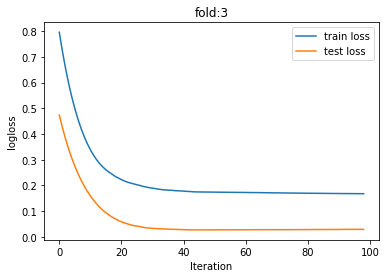

[I 2021-12-27 16:21:53,380] A new study created in memory with name: no-name-0fb0f0ab-8801-40f6-917f-7069ae343397
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.154665	Test's rmse: 0.391274


feature_fraction, val_score: 0.373033:  29%|############8                                | 2/7 [00:00<00:01,  4.86it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033


feature_fraction, val_score: 0.373033:  43%|###################2                         | 3/7 [00:00<00:00,  4.73it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121956	Test's rmse: 0.418672


[I 2021-12-27 16:21:54,031] Trial 2 finished with value: 0.41867181945067966 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.3730328037776354.
feature_fraction, val_score: 0.373033:  43%|###################2                         | 3/7 [00:00<00:00,  4.73it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121667	Test's rmse: 0.411929


feature_fraction, val_score: 0.373033:  57%|#########################7                   | 4/7 [00:00<00:00,  4.49it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033:  71%|################################1            | 5/7 [00:01<00:00,  4.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122753	Test's rmse: 0.417714
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033:  86%|######################################5      | 6/7 [00:01<00:00,  4.18it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.15737	Test's rmse: 0.378682
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033: 100%|#############################################| 7/7 [00:01<00:00,  3.79it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120118	Test's rmse: 0.417415


num_leaves, val_score: 0.373033:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:   5%|##5                                               | 1/20 [00:01<00:19,  1.02s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

num_leaves, val_score: 0.373033:  10%|#####                                             | 2/20 [00:01<00:17,  1.01it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  15%|#######5                                          | 3/20 [00:02<00:16,  1.02it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  20%|##########                                        | 4/20 [00:03<00:15,  1.06it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  25%|############5                                     | 5/20 [00:04<00:13,  1.15it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153027	Test's rmse: 0.375767
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  30%|###############                                   | 6/20 [00:05<00:10,  1.34it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159186	Test's rmse: 0.376065
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  35%|#################5                                | 7/20 [00:05<00:09,  1.38it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159186	Test's rmse: 0.376071
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  40%|####################                              | 8/20 [00:06<00:07,  1.68it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15923	Test's rmse: 0.376099
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.159223	Test's rmse: 0.371918


num_leaves, val_score: 0.371918:  45%|######################5                           | 9/20 [00:06<00:05,  2.13it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.371375:  55%|##########################9                      | 11/20 [00:07<00:03,  2.37it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.158799	Test's rmse: 0.371375
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[Lig

num_leaves, val_score: 0.371375:  60%|#############################4                   | 12/20 [00:07<00:02,  2.96it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	Train's rmse: 0.159614	Test's rmse: 0.372108
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.354284:  65%|###############################8                 | 13/20 [00:07<00:01,  3.70it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.155086	Test's rmse: 0.354284
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.348219:  75%|####################################7            | 15/20 [00:07<00:01,  3.32it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159203	Test's rmse: 0.376085
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[Lig

num_leaves, val_score: 0.348219:  80%|#######################################2         | 16/20 [00:08<00:01,  3.72it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153058	Test's rmse: 0.37575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.348219:  85%|#########################################6       | 17/20 [00:08<00:01,  2.77it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159187	Test's rmse: 0.376065
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.348219:  90%|############################################1    | 18/20 [00:09<00:00,  2.94it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159209	Test's rmse: 0.376077
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337830: 100%|#################################################| 20/20 [00:09<00:00,  2.10it/s]


Early stopping, best iteration is:
[31]	Train's rmse: 0.159713	Test's rmse: 0.376146
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196657	Test's rmse: 0.33783


bagging, val_score: 0.337830:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.331660:  10%|#####3                                               | 1/10 [00:00<00:00,  9.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196215	Test's rmse: 0.33166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197474	Test's rmse: 0.331642


bagging, val_score: 0.331642:  20%|##########6                                          | 2/10 [00:00<00:00,  9.04it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196717	Test's rmse: 0.337489


bagging, val_score: 0.330351:  40%|#####################2                               | 4/10 [00:00<00:00, 10.30it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.330351:  50%|##########################5                          | 5/10 [00:00<00:00, 10.30it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196523	Test's rmse: 0.335527
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.196505	Test's rmse: 0.333595


bagging, val_score: 0.330351:  60%|###############################8                     | 6/10 [00:00<00:00,  9.30it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.330351:  70%|#####################################                | 7/10 [00:00<00:00,  7.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196339	Test's rmse: 0.333108
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


bagging, val_score: 0.330351:  80%|##########################################4          | 8/10 [00:00<00:00,  7.79it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196337	Test's rmse: 0.333026
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196266	Test's rmse: 0.334161


bagging, val_score: 0.330351: 100%|####################################################| 10/10 [00:01<00:00,  8.37it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196401	Test's rmse: 0.33544



feature_fraction_stage2, val_score: 0.330351:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.330351:  33%|############6                         | 1/3 [00:00<00:00,  8.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.330351:  67%|#########################3            | 2/3 [00:00<00:00,  7.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196663	Test's rmse: 0.331065
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


feature_fraction_stage2, val_score: 0.330351: 100%|######################################| 3/3 [00:00<00:00,  7.79it/s]


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196516	Test's rmse: 0.331395


regularization_factors, val_score: 0.330351:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.330351:   5%|#9                                    | 1/20 [00:00<00:02,  7.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196476	Test's rmse: 0.331284
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196291	Test's rmse: 0.330352

regularization_factors, val_score: 0.330351:  10%|###8                                  | 2/20 [00:00<00:02,  8.53it/s]


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.330351:  15%|#####7                                | 3/20 [00:00<00:01,  8.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196485	Test's rmse: 0.331434
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197122	Test's rmse: 0.334701


regularization_factors, val_score: 0.330351:  20%|#######6                              | 4/20 [00:00<00:01,  8.96it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196433	Test's rmse: 0.330625


regularization_factors, val_score: 0.330351:  30%|###########4                          | 6/20 [00:00<00:01,  9.65it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196405	Test's rmse: 0.330741
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.330351:  35%|#############3                        | 7/20 [00:00<00:01,  9.96it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196404	Test's rmse: 0.330768
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.330351:  40%|###############2                      | 8/20 [00:00<00:01,  9.96it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.330351:  45%|#################1                    | 9/20 [00:00<00:01, 10.13it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196547	Test's rmse: 0.33253


regularization_factors, val_score: 0.330351:  50%|##################5                  | 10/20 [00:01<00:00, 10.13it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196291	Test's rmse: 0.330352
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validat

regularization_factors, val_score: 0.330351:  55%|####################3                | 11/20 [00:01<00:00,  9.73it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351


regularization_factors, val_score: 0.330351:  60%|######################2              | 12/20 [00:01<00:00,  9.41it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351


regularization_factors, val_score: 0.330351:  65%|########################             | 13/20 [00:01<00:00,  8.98it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351


regularization_factors, val_score: 0.330351:  75%|###########################7         | 15/20 [00:01<00:00,  8.81it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351


regularization_factors, val_score: 0.330351:  80%|#############################6       | 16/20 [00:01<00:00,  8.86it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351


regularization_factors, val_score: 0.330351:  85%|###############################4     | 17/20 [00:01<00:00,  8.95it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19629	Test's rmse: 0.330351


regularization_factors, val_score: 0.329948:  90%|#################################3   | 18/20 [00:01<00:00,  9.01it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196311	Test's rmse: 0.329948


regularization_factors, val_score: 0.329948:  95%|###################################1 | 19/20 [00:02<00:00,  8.96it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196293	Test's rmse: 0.330393


[I 2021-12-27 16:22:08,425] Trial 58 finished with value: 0.3303934296710763 and parameters: {'lambda_l1': 0.054616509039495706, 'lambda_l2': 1.7369668668336414e-08}. Best is trial 57 with value: 0.32994804135152506.
regularization_factors, val_score: 0.329948: 100%|#####################################| 20/20 [00:02<00:00,  8.98it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196292	Test's rmse: 0.330373


[I 2021-12-27 16:22:08,537] Trial 59 finished with value: 0.3303727130187044 and parameters: {'lambda_l1': 0.0281085049968261, 'lambda_l2': 3.413273720415162e-07}. Best is trial 57 with value: 0.32994804135152506.
min_data_in_leaf, val_score: 0.329948:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196599	Test's rmse: 0.330269


min_data_in_leaf, val_score: 0.329948:  20%|#########                                    | 1/5 [00:00<00:00,  9.52it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196313	Test's rmse: 0.329944


min_data_in_leaf, val_score: 0.329944:  40%|##################                           | 2/5 [00:00<00:00,  8.58it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.329944:  80%|####################################         | 4/5 [00:00<00:00,  9.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196599	Test's rmse: 0.330269
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.265226	Test's rmse: 0.477702


[I 2021-12-27 16:22:08,990] Trial 63 finished with value: 0.4777019897455321 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.3299439778591297.
min_data_in_leaf, val_score: 0.329944:  80%|####################################         | 4/5 [00:00<00:00,  9.09it/s][I 2021-12-27 16:22:09,078] Trial 64 finished with value: 0.42818865016846486 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.3299439778591297.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.236694	Test's rmse: 0.428189


min_data_in_leaf, val_score: 0.329944: 100%|#############################################| 5/5 [00:00<00:00,  9.33it/s]


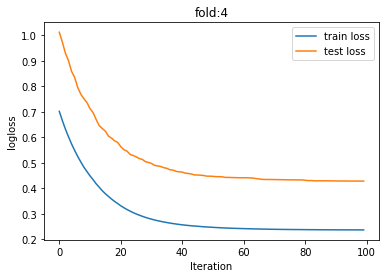

RMSE: [0.32262792863385437, 0.10144739233251607, 0.13696088206701426, 0.02030612378098113, 0.3299439781659125]
RMSE: 0.1822572609960557


In [7]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_opt = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = opt_lgb.train(
                    params,                           # ハイパーパラメータをセット
                    lgb_train,                        # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_opt.append(rmse)

print("RMSE:", cv_result_opt)
print("RMSE:", np.mean(cv_result_opt))

## Optuna によるハイパーパラメーターチューニング

In [8]:
def objective(trial):

    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    num_leaves =  trial.suggest_int("num_leaves", 5, 50)
    tree_learner = trial.suggest_categorical('tree_learner', ["serial", "feature", "data", "voting"])

    params = {
            'task': 'train',                 # タスクを訓練に設定
            'boosting_type': 'gbdt',         # GBDTを指定
            'objective': 'regression',       # 回帰を指定
            'metric': {'rmse'},              # 回帰の損失（誤差）
            'learning_rate': learning_rate,  # 学習率
            'num_leaves': num_leaves,
            'tree_learner': tree_learner,
            'seed': SEED                     # シード値
            }

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )
    
    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)

    return rmse

[I 2021-12-27 16:22:09,310] A new study created in memory with name: no-name-fbb67571-5699-4c7f-a0d2-6c5015b31b89


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	Train's rmse: 0.122538	Test's rmse: 0.344188


[I 2021-12-27 16:22:09,546] Trial 0 finished with value: 0.34418790326841464 and parameters: {'learning_rate': 0.365861781142683, 'num_leaves': 44, 'tree_learner': 'voting'}. Best is trial 0 with value: 0.34418790326841464.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.133032	Test's rmse: 0.338182

[I 2021-12-27 16:22:09,725] Trial 1 finished with value: 0.33818184482493474 and parameters: {'learning_rate': 0.4855046742983812, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.33818184482493474.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:09,814] Trial 2 finished with value: 0.3512140056117329 and parameters: {'learning_rate': 0.26336054487817234, 'num_leaves': 17, 'tree_learner': 'feature'}. Best is trial 1 with value: 0.33818184482493474.
[I 2021-12-27 16:22:09,872] Trial 3 finished with value: 0.34622828322185556 and parameters: {'learning_rate': 0.614654134255239, 'num_leaves': 12, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.33818184482493474.


Early stopping, best iteration is:
[20]	Train's rmse: 0.132593	Test's rmse: 0.351214
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.171533	Test's rmse: 0.346228
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, bes

[I 2021-12-27 16:22:10,006] Trial 4 finished with value: 0.3347136144359734 and parameters: {'learning_rate': 0.49932914557142405, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.
[I 2021-12-27 16:22:10,102] Trial 5 finished with value: 0.34307554506906657 and parameters: {'learning_rate': 0.16532741397772194, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.3347136144359734.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	Train's rmse: 0.145877	Test's rmse: 0.343076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.15618	Test's rmse: 0.348169


[I 2021-12-27 16:22:10,207] Trial 6 finished with value: 0.34816920601250556 and parameters: {'learning_rate': 0.5723287218586496, 'num_leaves': 19, 'tree_learner': 'data'}. Best is trial 4 with value: 0.3347136144359734.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:10,464] Trial 7 finished with value: 0.3459660526627928 and parameters: {'learning_rate': 0.6019213212109507, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 4 with value: 0.3347136144359734.
[I 2021-12-27 16:22:10,548] Trial 8 finished with value: 0.34714659122032837 and parameters: {'learning_rate': 0.9592591786684295, 'num_leaves': 18, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.


Early stopping, best iteration is:
[3]	Train's rmse: 0.169917	Test's rmse: 0.345966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	Train's rmse: 0.175923	Test's rmse: 0.347147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:22:10,640] Trial 9 finished with value: 0.33824259965497966 and parameters: {'learning_rate': 0.6053081556469473, 'num_leaves': 21, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.3347136144359734.
[I 2021-12-27 16:22:10,759] Trial 10 finished with value: 0.33893494855757356 and parameters: {'learning_rate': 0.8362282173941291, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.120926	Test's rmse: 0.338935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.162926	Test's rmse: 0.345477


[I 2021-12-27 16:22:10,873] Trial 11 finished with value: 0.3454767823275073 and parameters: {'learning_rate': 0.4045091948062055, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.
[I 2021-12-27 16:22:11,018] Trial 12 finished with value: 0.34726390219183406 and parameters: {'learning_rate': 0.4380369352949889, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.14596	Test's rmse: 0.347264
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:11,144] Trial 13 finished with value: 0.34441070166200366 and parameters: {'learning_rate': 0.7633403581866547, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.
[I 2021-12-27 16:22:11,237] Trial 14 finished with value: 0.34000430820873434 and parameters: {'learning_rate': 0.47285122622798736, 'num_leaves': 27, 'tree_learner': 'feature'}. Best is trial 4 with value: 0.3347136144359734.


Early stopping, best iteration is:
[2]	Train's rmse: 0.170293	Test's rmse: 0.344411
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.159711	Test's rmse: 0.340004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:11,347] Trial 15 finished with value: 0.34693415531354316 and parameters: {'learning_rate': 0.2630736176640436, 'num_leaves': 27, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.


Early stopping, best iteration is:
[16]	Train's rmse: 0.148636	Test's rmse: 0.346934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.175558	Test's rmse: 0.349063

[I 2021-12-27 16:22:11,537] Trial 16 finished with value: 0.3490633553847698 and parameters: {'learning_rate': 0.719500958578655, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:11,972] Trial 17 finished with value: 0.35332129886101304 and parameters: {'learning_rate': 0.3069840302397053, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.3347136144359734.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.103039	Test's rmse: 0.353321
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.134802	Test's rmse: 0.333611

[I 2021-12-27 16:22:12,126] Trial 18 finished with value: 0.3336105950939092 and parameters: {'learning_rate': 0.5054189615270691, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:12,373] Trial 19 finished with value: 0.34313800881853473 and parameters: {'learning_rate': 0.11110493022455153, 'num_leaves': 32, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.
[I 2021-12-27 16:22:12,500] Trial 20 finished with value: 0.3414396236254616 and parameters: {'learning_rate': 0.7017046513161349, 'num_leaves': 25, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.


Early stopping, best iteration is:
[43]	Train's rmse: 0.14352	Test's rmse: 0.343138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.163734	Test's rmse: 0.34144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:12,684] Trial 21 finished with value: 0.33787434621694257 and parameters: {'learning_rate': 0.47946019398169704, 'num_leaves': 35, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.
[I 2021-12-27 16:22:12,817] Trial 22 finished with value: 0.33371591646917464 and parameters: {'learning_rate': 0.5214732689810356, 'num_leaves': 34, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.


Early stopping, best iteration is:
[16]	Train's rmse: 0.134114	Test's rmse: 0.337874
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.138721	Test's rmse: 0.333716
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:12,916] Trial 23 finished with value: 0.3392591930194975 and parameters: {'learning_rate': 0.5101972682354633, 'num_leaves': 23, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.


Early stopping, best iteration is:
[5]	Train's rmse: 0.158349	Test's rmse: 0.339259
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:13,202] Trial 24 finished with value: 0.3499644748820828 and parameters: {'learning_rate': 0.3483748779013355, 'num_leaves': 30, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.
[I 2021-12-27 16:22:13,356] Trial 25 finished with value: 0.3431844667367912 and parameters: {'learning_rate': 0.6461765173020895, 'num_leaves': 42, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0986593	Test's rmse: 0.349964
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.165949	Test's rmse: 0.343184


[I 2021-12-27 16:22:13,489] Trial 26 finished with value: 0.3353801560636247 and parameters: {'learning_rate': 0.5273915524303631, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 18 with value: 0.3336105950939092.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.145754	Test's rmse: 0.33538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:13,671] Trial 27 finished with value: 0.34738940040690697 and parameters: {'learning_rate': 0.400927016816351, 'num_leaves': 30, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.
[I 2021-12-27 16:22:13,813] Trial 28 finished with value: 0.33950621952161664 and parameters: {'learning_rate': 0.8460597444845104, 'num_leaves': 37, 'tree_learner': 'feature'}. Best is trial 18 with value: 0.3336105950939092.


Early stopping, best iteration is:
[27]	Train's rmse: 0.130248	Test's rmse: 0.347389
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.165669	Test's rmse: 0.339506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-12-27 16:22:14,011] Trial 29 finished with value: 0.3442095550135473 and parameters: {'learning_rate': 0.342308526059727, 'num_leaves': 45, 'tree_learner': 'data'}. Best is trial 18 with value: 0.3336105950939092.


[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	Train's rmse: 0.123727	Test's rmse: 0.34421


[I 2021-12-27 16:22:14,140] Trial 30 finished with value: 0.3550592573077228 and parameters: {'learning_rate': 0.6798546490993118, 'num_leaves': 41, 'tree_learner': 'voting'}. Best is trial 18 with value: 0.3336105950939092.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.182808	Test's rmse: 0.355059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:14,277] Trial 31 finished with value: 0.3506588909049196 and parameters: {'learning_rate': 0.5311375171194297, 'num_leaves': 34, 'tree_learner': 'data'}. Best is trial 18 with value: 0.3336105950939092.
[I 2021-12-27 16:22:14,381] Trial 32 finished with value: 0.35080327266471384 and parameters: {'learning_rate': 0.543348602149811, 'num_leaves': 32, 'tree_learner': 'data'}. Best is trial 18 with value: 0.3336105950939092.


Early stopping, best iteration is:
[7]	Train's rmse: 0.149335	Test's rmse: 0.350659
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.148958	Test's rmse: 0.350803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:14,590] Trial 33 finished with value: 0.3502547074772608 and parameters: {'learning_rate': 0.44130467336070145, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 18 with value: 0.3336105950939092.
[I 2021-12-27 16:22:14,698] Trial 34 finished with value: 0.35085820845893195 and parameters: {'learning_rate': 0.5482342160685318, 'num_leaves': 28, 'tree_learner': 'data'}. Best is trial 18 with value: 0.3336105950939092.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0879308	Test's rmse: 0.350255
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.149171	Test's rmse: 0.350858
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:14,838] Trial 35 finished with value: 0.33170109118543084 and parameters: {'learning_rate': 0.492502792909591, 'num_leaves': 35, 'tree_learner': 'feature'}. Best is trial 35 with value: 0.33170109118543084.
[I 2021-12-27 16:22:14,973] Trial 36 finished with value: 0.34868590083430157 and parameters: {'learning_rate': 0.24836450778814262, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 35 with value: 0.33170109118543084.


Early stopping, best iteration is:
[10]	Train's rmse: 0.13496	Test's rmse: 0.331701
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.166115	Test's rmse: 0.348686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:15,069] Trial 37 finished with value: 0.34109082483547765 and parameters: {'learning_rate': 0.4408063885966882, 'num_leaves': 24, 'tree_learner': 'feature'}. Best is trial 35 with value: 0.33170109118543084.
[I 2021-12-27 16:22:15,176] Trial 38 finished with value: 0.34597967698553855 and parameters: {'learning_rate': 0.6017500053478786, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 35 with value: 0.33170109118543084.


Early stopping, best iteration is:
[5]	Train's rmse: 0.162446	Test's rmse: 0.341091
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.169937	Test's rmse: 0.34598
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best 

[I 2021-12-27 16:22:15,265] Trial 39 finished with value: 0.3520352756101194 and parameters: {'learning_rate': 0.6519201854300846, 'num_leaves': 13, 'tree_learner': 'voting'}. Best is trial 35 with value: 0.33170109118543084.
[I 2021-12-27 16:22:15,468] Trial 40 finished with value: 0.34796612852903386 and parameters: {'learning_rate': 0.3892866077942547, 'num_leaves': 29, 'tree_learner': 'feature'}. Best is trial 35 with value: 0.33170109118543084.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0879378	Test's rmse: 0.347966


[I 2021-12-27 16:22:15,592] Trial 41 finished with value: 0.33375650893944164 and parameters: {'learning_rate': 0.5164449213939057, 'num_leaves': 32, 'tree_learner': 'data'}. Best is trial 35 with value: 0.33170109118543084.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.138944	Test's rmse: 0.333756
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:15,729] Trial 42 finished with value: 0.3483636432659457 and parameters: {'learning_rate': 0.5761859069711294, 'num_leaves': 32, 'tree_learner': 'feature'}. Best is trial 35 with value: 0.33170109118543084.
[I 2021-12-27 16:22:15,872] Trial 43 finished with value: 0.34200355575344893 and parameters: {'learning_rate': 0.48262164055782947, 'num_leaves': 36, 'tree_learner': 'data'}. Best is trial 35 with value: 0.33170109118543084.


Early stopping, best iteration is:
[3]	Train's rmse: 0.173376	Test's rmse: 0.348364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.137055	Test's rmse: 0.342004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, bes

[I 2021-12-27 16:22:15,929] Trial 44 finished with value: 0.3278165769044114 and parameters: {'learning_rate': 0.5057187337928578, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.3278165769044114.
[I 2021-12-27 16:22:15,984] Trial 45 finished with value: 0.3284657441779182 and parameters: {'learning_rate': 0.5667507854685649, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.3278165769044114.
[I 2021-12-27 16:22:16,051] Trial 46 finished with value: 0.3240212012186768 and parameters: {'learning_rate': 0.5766656488633808, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,109] Trial 47 finished with value: 0.3289552559846293 and parameters: {'learning_rate': 0.5799099085786137, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.173438	Test's rmse: 0.328466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.104661	Test's rmse: 0.324021
[LightGBM] [Warning

[I 2021-12-27 16:22:16,175] Trial 48 finished with value: 0.3292984853652232 and parameters: {'learning_rate': 0.7823238199046769, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,246] Trial 49 finished with value: 0.3613881809591341 and parameters: {'learning_rate': 0.9799720960762262, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,293] Trial 50 finished with value: 0.32921156922829153 and parameters: {'learning_rate': 0.7630942047364111, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	Train's rmse: 0.124911	Test's rmse: 0.329298
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.167769	Test's rmse: 0.361388
[LightGBM] [Warning

[I 2021-12-27 16:22:16,361] Trial 51 finished with value: 0.32952438639171544 and parameters: {'learning_rate': 0.7735422074236302, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,427] Trial 52 finished with value: 0.3392891599688804 and parameters: {'learning_rate': 0.8062590813613819, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,506] Trial 53 finished with value: 0.3535479567389913 and parameters: {'learning_rate': 0.8718877606186736, 'num_leaves': 12, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.


Early stopping, best iteration is:
[6]	Train's rmse: 0.169011	Test's rmse: 0.329524
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.18282	Test's rmse: 0.339289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best 

[I 2021-12-27 16:22:16,557] Trial 54 finished with value: 0.32737066403822745 and parameters: {'learning_rate': 0.8998129511276862, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,643] Trial 55 finished with value: 0.35254766981425867 and parameters: {'learning_rate': 0.9231748814730887, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,736] Trial 56 finished with value: 0.34662520304066907 and parameters: {'learning_rate': 0.9204753545365868, 'num_leaves': 14, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.


Early stopping, best iteration is:
[2]	Train's rmse: 0.178403	Test's rmse: 0.327371
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	Train's rmse: 0.102892	Test's rmse: 0.352548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, bes

[I 2021-12-27 16:22:16,808] Trial 57 finished with value: 0.3533733178238776 and parameters: {'learning_rate': 0.7346500562729055, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,871] Trial 58 finished with value: 0.3327068772033334 and parameters: {'learning_rate': 0.6318573532245535, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:16,945] Trial 59 finished with value: 0.3482091591935603 and parameters: {'learning_rate': 0.5816648272388742, 'num_leaves': 15, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.185356	Test's rmse: 0.353373
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.160489	Test's rmse: 0.332707
[LightGBM] [Warning]

[I 2021-12-27 16:22:17,007] Trial 60 finished with value: 0.35572511707095233 and parameters: {'learning_rate': 0.7015866663075805, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:17,079] Trial 61 finished with value: 0.3456145618804242 and parameters: {'learning_rate': 0.7885405881232912, 'num_leaves': 11, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:17,140] Trial 62 finished with value: 0.33703865732881433 and parameters: {'learning_rate': 0.8775526586765696, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.153924	Test's rmse: 0.355725
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.174705	Test's rmse: 0.345615
[LightGBM] [Warning]

[I 2021-12-27 16:22:17,214] Trial 63 finished with value: 0.3298410408420863 and parameters: {'learning_rate': 0.7377234037028284, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:17,282] Trial 64 finished with value: 0.3311244386617197 and parameters: {'learning_rate': 0.8192938899259918, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 46 with value: 0.3240212012186768.
[I 2021-12-27 16:22:17,352] Trial 65 finished with value: 0.3218883438826219 and parameters: {'learning_rate': 0.6724046804522255, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 65 with value: 0.3218883438826219.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.194126	Test's rmse: 0.329841
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	T

[I 2021-12-27 16:22:17,422] Trial 66 finished with value: 0.32541625084509074 and parameters: {'learning_rate': 0.6657285846363099, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 65 with value: 0.3218883438826219.
[I 2021-12-27 16:22:17,488] Trial 67 finished with value: 0.3327453328362737 and parameters: {'learning_rate': 0.6073612066429784, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 65 with value: 0.3218883438826219.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.110853	Test's rmse: 0.325416
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.113471	Test's rmse: 0.332745
[LightGBM] [Warnin

[I 2021-12-27 16:22:17,574] Trial 68 finished with value: 0.34736883556613335 and parameters: {'learning_rate': 0.6816891729087461, 'num_leaves': 16, 'tree_learner': 'voting'}. Best is trial 65 with value: 0.3218883438826219.
[I 2021-12-27 16:22:17,655] Trial 69 finished with value: 0.3484424527845376 and parameters: {'learning_rate': 0.5634198669544201, 'num_leaves': 11, 'tree_learner': 'voting'}. Best is trial 65 with value: 0.3218883438826219.
[I 2021-12-27 16:22:17,745] Trial 70 finished with value: 0.34365016201627646 and parameters: {'learning_rate': 0.6377655631733063, 'num_leaves': 20, 'tree_learner': 'voting'}. Best is trial 65 with value: 0.3218883438826219.


Early stopping, best iteration is:
[6]	Train's rmse: 0.150224	Test's rmse: 0.347369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.127462	Test's rmse: 0.348442
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, bes

[I 2021-12-27 16:22:17,830] Trial 71 finished with value: 0.31698956233652603 and parameters: {'learning_rate': 0.665382290414195, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 71 with value: 0.31698956233652603.
[I 2021-12-27 16:22:17,946] Trial 72 finished with value: 0.3174961434861899 and parameters: {'learning_rate': 0.6644835481752402, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 71 with value: 0.31698956233652603.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	Train's rmse: 0.0840241	Test's rmse: 0.31699
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.139076	Test's rmse: 0.317496


[I 2021-12-27 16:22:18,063] Trial 73 finished with value: 0.32486715181358344 and parameters: {'learning_rate': 0.6874217052076658, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 71 with value: 0.31698956233652603.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.136457	Test's rmse: 0.324867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:18,239] Trial 74 finished with value: 0.3060021768681886 and parameters: {'learning_rate': 0.6667334354547906, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:18,327] Trial 75 finished with value: 0.35178639532802614 and parameters: {'learning_rate': 0.659108213943972, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 74 with value: 0.3060021768681886.


Early stopping, best iteration is:
[36]	Train's rmse: 0.0784003	Test's rmse: 0.306002
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.144687	Test's rmse: 0.351786
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until 

[I 2021-12-27 16:22:18,492] Trial 76 finished with value: 0.3255476314473759 and parameters: {'learning_rate': 0.6776253562955405, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:18,646] Trial 77 finished with value: 0.32223033758364755 and parameters: {'learning_rate': 0.6929626123295566, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


Early stopping, best iteration is:
[5]	Train's rmse: 0.152582	Test's rmse: 0.325548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.155788	Test's rmse: 0.32223


[I 2021-12-27 16:22:18,791] Trial 78 finished with value: 0.34625886191549815 and parameters: {'learning_rate': 0.6964829026502019, 'num_leaves': 13, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	Train's rmse: 0.125296	Test's rmse: 0.346259
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:18,901] Trial 79 finished with value: 0.35218078851253204 and parameters: {'learning_rate': 0.7197030233533921, 'num_leaves': 11, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:19,023] Trial 80 finished with value: 0.3445222104658245 and parameters: {'learning_rate': 0.6261795060389412, 'num_leaves': 18, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


Early stopping, best iteration is:
[2]	Train's rmse: 0.182014	Test's rmse: 0.352181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.168629	Test's rmse: 0.344522
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:22:19,103] Trial 81 finished with value: 0.3255238484907054 and parameters: {'learning_rate': 0.6748131919131676, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:19,215] Trial 82 finished with value: 0.31092817494078856 and parameters: {'learning_rate': 0.6674568593744942, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.046439	Test's rmse: 0.310928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0315294	Test's rmse

[I 2021-12-27 16:22:19,318] Trial 83 finished with value: 0.3229130080744064 and parameters: {'learning_rate': 0.7282559772893055, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:19,393] Trial 84 finished with value: 0.3509630219186765 and parameters: {'learning_rate': 0.7430159486877104, 'num_leaves': 10, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:19,473] Trial 85 finished with value: 0.3202138555913711 and parameters: {'learning_rate': 0.7080395856500951, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.181177	Test's rmse: 0.350963
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.155675	Test's rmse: 0.320214
[LightGBM] [Warning]

[I 2021-12-27 16:22:19,568] Trial 86 finished with value: 0.3508462324325712 and parameters: {'learning_rate': 0.7234182349102731, 'num_leaves': 12, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:19,639] Trial 87 finished with value: 0.323061088574167 and parameters: {'learning_rate': 0.6112996844277678, 'num_leaves': 6, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:19,719] Trial 88 finished with value: 0.3484759506292763 and parameters: {'learning_rate': 0.6093147052811383, 'num_leaves': 9, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


Early stopping, best iteration is:
[2]	Train's rmse: 0.179851	Test's rmse: 0.350846
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.14661	Test's rmse: 0.323061
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:22:19,858] Trial 89 finished with value: 0.3563311482931849 and parameters: {'learning_rate': 0.7075532212983181, 'num_leaves': 13, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0698478	Test's rmse: 0.356331
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.159464	Test's rmse: 0.327807


[I 2021-12-27 16:22:19,938] Trial 90 finished with value: 0.3278065892029281 and parameters: {'learning_rate': 0.6523354322129759, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:20,048] Trial 91 finished with value: 0.3245563198340559 and parameters: {'learning_rate': 0.7552556168939503, 'num_leaves': 6, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:20,126] Trial 92 finished with value: 0.32622685584783356 and parameters: {'learning_rate': 0.5913885281987276, 'num_leaves': 6, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	Train's rmse: 0.089195	Test's rmse: 0.324556
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	Train's rmse: 0.156726	Test's rmse: 0.326227
[LightGBM] [Warning

[I 2021-12-27 16:22:20,211] Trial 93 finished with value: 0.3366694473514907 and parameters: {'learning_rate': 0.6217473192438971, 'num_leaves': 10, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:20,304] Trial 94 finished with value: 0.3120661011321638 and parameters: {'learning_rate': 0.6465788777492969, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.145855	Test's rmse: 0.336669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	Train's rmse: 0.0908669	Test's rmse: 0.312066
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

[I 2021-12-27 16:22:20,406] Trial 95 finished with value: 0.3121437625420051 and parameters: {'learning_rate': 0.6440896052567635, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:20,505] Trial 96 finished with value: 0.3496425260325191 and parameters: {'learning_rate': 0.6484989630770087, 'num_leaves': 11, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:20,585] Trial 97 finished with value: 0.32001528135271295 and parameters: {'learning_rate': 0.7170635201287242, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


Early stopping, best iteration is:
[24]	Train's rmse: 0.0910109	Test's rmse: 0.312144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.143434	Test's rmse: 0.349643
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, be

[I 2021-12-27 16:22:20,674] Trial 98 finished with value: 0.34781935371304984 and parameters: {'learning_rate': 0.7513047651787493, 'num_leaves': 12, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.
[I 2021-12-27 16:22:20,770] Trial 99 finished with value: 0.35485407914385986 and parameters: {'learning_rate': 0.7115613016648923, 'num_leaves': 9, 'tree_learner': 'serial'}. Best is trial 74 with value: 0.3060021768681886.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.176358	Test's rmse: 0.347819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	Train's rmse: 0.122134	Test's rmse: 0.354854
{'learning_rate': 0

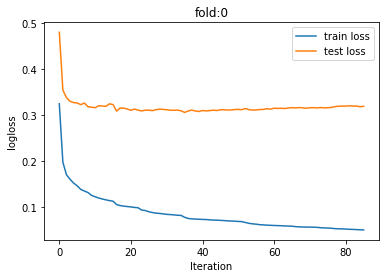

[I 2021-12-27 16:22:21,037] A new study created in memory with name: no-name-e5b2efa9-a66b-4bfe-97a6-197c5b900a4c


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116216	Test's rmse: 0.128094


[I 2021-12-27 16:22:21,277] Trial 0 finished with value: 0.1280939699870691 and parameters: {'learning_rate': 0.23018857747259022, 'num_leaves': 29, 'tree_learner': 'feature'}. Best is trial 0 with value: 0.1280939699870691.
[I 2021-12-27 16:22:21,448] Trial 1 finished with value: 0.11265433349346586 and parameters: {'learning_rate': 0.4224301905736748, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.11265433349346586.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.146866	Test's rmse: 0.112654
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:21,598] Trial 2 finished with value: 0.12897437970355338 and parameters: {'learning_rate': 0.8477191551436323, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.11265433349346586.
[I 2021-12-27 16:22:21,701] Trial 3 finished with value: 0.12290120407131627 and parameters: {'learning_rate': 0.8267531768982845, 'num_leaves': 19, 'tree_learner': 'data'}. Best is trial 1 with value: 0.11265433349346586.


Early stopping, best iteration is:
[11]	Train's rmse: 0.158479	Test's rmse: 0.128974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.154575	Test's rmse: 0.122901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until 

[I 2021-12-27 16:22:21,781] Trial 4 finished with value: 0.12976857051605437 and parameters: {'learning_rate': 0.9224393404625999, 'num_leaves': 14, 'tree_learner': 'feature'}. Best is trial 1 with value: 0.11265433349346586.
[I 2021-12-27 16:22:21,950] Trial 5 finished with value: 0.11604951594415668 and parameters: {'learning_rate': 0.5903720761134541, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 1 with value: 0.11265433349346586.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	Train's rmse: 0.153819	Test's rmse: 0.11605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:22,076] Trial 6 finished with value: 0.12548017248029955 and parameters: {'learning_rate': 0.2419785482746114, 'num_leaves': 13, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.11265433349346586.
[I 2021-12-27 16:22:22,214] Trial 7 finished with value: 0.12453121989864507 and parameters: {'learning_rate': 0.7054313292740293, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.11265433349346586.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111807	Test's rmse: 0.12548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	Train's rmse: 0.152604	Test's rmse: 0.124531
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Tr

[I 2021-12-27 16:22:22,287] Trial 8 finished with value: 0.12467917018243443 and parameters: {'learning_rate': 0.8467152492516271, 'num_leaves': 9, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.11265433349346586.


Early stopping, best iteration is:
[18]	Train's rmse: 0.136388	Test's rmse: 0.124679
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	Train's rmse: 0.150945	Test's rmse: 0.122056

[I 2021-12-27 16:22:22,482] Trial 9 finished with value: 0.12205642940862084 and parameters: {'learning_rate': 0.38973450781403085, 'num_leaves': 35, 'tree_learner': 'data'}. Best is trial 1 with value: 0.11265433349346586.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:22,707] Trial 10 finished with value: 0.10996480111810611 and parameters: {'learning_rate': 0.43848430790671045, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.10996480111810611.


Early stopping, best iteration is:
[21]	Train's rmse: 0.147376	Test's rmse: 0.109965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:22,989] Trial 11 finished with value: 0.11703681140506164 and parameters: {'learning_rate': 0.41341360226163637, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.10996480111810611.


Early stopping, best iteration is:
[32]	Train's rmse: 0.144969	Test's rmse: 0.117037
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:23,333] Trial 12 finished with value: 0.11365455218418735 and parameters: {'learning_rate': 0.44584503760453353, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.10996480111810611.


Early stopping, best iteration is:
[26]	Train's rmse: 0.146427	Test's rmse: 0.113655
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:23,686] Trial 13 finished with value: 0.11220286566033146 and parameters: {'learning_rate': 0.10958921961050283, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.10996480111810611.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147977	Test's rmse: 0.112203
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:23,967] Trial 14 finished with value: 0.11849533150674522 and parameters: {'learning_rate': 0.14862444706125044, 'num_leaves': 42, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.10996480111810611.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133922	Test's rmse: 0.118495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:24,205] Trial 15 finished with value: 0.11384769451378567 and parameters: {'learning_rate': 0.5992769137363322, 'num_leaves': 44, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.10996480111810611.


Early stopping, best iteration is:
[25]	Train's rmse: 0.139735	Test's rmse: 0.113848
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:24,533] Trial 16 finished with value: 0.1096250569734718 and parameters: {'learning_rate': 0.1234187588315436, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 16 with value: 0.1096250569734718.
[I 2021-12-27 16:22:24,701] Trial 17 finished with value: 0.1113285473635086 and parameters: {'learning_rate': 0.29658575330007836, 'num_leaves': 23, 'tree_learner': 'voting'}. Best is trial 16 with value: 0.1096250569734718.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145459	Test's rmse: 0.109625
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	Train's rmse: 0.144053	Test's rmse: 0.111329
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:24,919] Trial 18 finished with value: 0.10888180316190495 and parameters: {'learning_rate': 0.5165028782277457, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 18 with value: 0.10888180316190495.


Early stopping, best iteration is:
[28]	Train's rmse: 0.135077	Test's rmse: 0.108882
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	Train's rmse: 0.152157	Test's rmse: 0.124408


[I 2021-12-27 16:22:25,115] Trial 19 finished with value: 0.12440763356061574 and parameters: {'learning_rate': 0.711208015701533, 'num_leaves': 40, 'tree_learner': 'data'}. Best is trial 18 with value: 0.10888180316190495.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.126913	Test's rmse: 0.108555


[I 2021-12-27 16:22:25,331] Trial 20 finished with value: 0.10855487146761844 and parameters: {'learning_rate': 0.5250595425570751, 'num_leaves': 38, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:25,565] Trial 21 finished with value: 0.11217870945571773 and parameters: {'learning_rate': 0.5226927056258638, 'num_leaves': 40, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.
[I 2021-12-27 16:22:25,741] Trial 22 finished with value: 0.11036572330747405 and parameters: {'learning_rate': 0.6516071689572714, 'num_leaves': 37, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[36]	Train's rmse: 0.1259	Test's rmse: 0.112179
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	Train's rmse: 0.139039	Test's rmse: 0.110366
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:22:25,966] Trial 23 finished with value: 0.11578324941213741 and parameters: {'learning_rate': 0.5185439129124211, 'num_leaves': 46, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.
[I 2021-12-27 16:22:26,147] Trial 24 finished with value: 0.11558074179115188 and parameters: {'learning_rate': 0.2988882081967613, 'num_leaves': 26, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.142824	Test's rmse: 0.115581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:26,388] Trial 25 finished with value: 0.10867301104605968 and parameters: {'learning_rate': 0.34703849792103725, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[40]	Train's rmse: 0.136997	Test's rmse: 0.108673
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:26,611] Trial 26 finished with value: 0.10979489879777159 and parameters: {'learning_rate': 0.3487810164944869, 'num_leaves': 38, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.
[I 2021-12-27 16:22:26,788] Trial 27 finished with value: 0.11210377120550975 and parameters: {'learning_rate': 0.5096246101734289, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[36]	Train's rmse: 0.143313	Test's rmse: 0.109795
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	Train's rmse: 0.141698	Test's rmse: 0.112104


[I 2021-12-27 16:22:26,924] Trial 28 finished with value: 0.1100343348415512 and parameters: {'learning_rate': 0.4866736126117922, 'num_leaves': 25, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.162476	Test's rmse: 0.110034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:27,220] Trial 29 finished with value: 0.12359475921506387 and parameters: {'learning_rate': 0.2133136491371368, 'num_leaves': 46, 'tree_learner': 'feature'}. Best is trial 20 with value: 0.10855487146761844.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119922	Test's rmse: 0.123595
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	Train's rmse: 0.158949	Test's rmse: 0.117876


[I 2021-12-27 16:22:27,401] Trial 30 finished with value: 0.11787626841356617 and parameters: {'learning_rate': 0.5924261182609082, 'num_leaves': 28, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:27,642] Trial 31 finished with value: 0.12408718578111351 and parameters: {'learning_rate': 0.1848920474111562, 'num_leaves': 37, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124169	Test's rmse: 0.124087
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.145145	Test's rmse: 0.113217

[I 2021-12-27 16:22:27,828] Trial 32 finished with value: 0.11321667680576131 and parameters: {'learning_rate': 0.33558852815056006, 'num_leaves': 41, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	Train's rmse: 0.143099	Test's rmse: 0.112013


[I 2021-12-27 16:22:28,004] Trial 33 finished with value: 0.11201278083659358 and parameters: {'learning_rate': 0.2567620195349922, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 20 with value: 0.10855487146761844.
[I 2021-12-27 16:22:28,189] Trial 34 finished with value: 0.11896528436217628 and parameters: {'learning_rate': 0.6793728184488126, 'num_leaves': 46, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.142621	Test's rmse: 0.118965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:28,359] Trial 35 finished with value: 0.1211450318479667 and parameters: {'learning_rate': 0.3741855077083231, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 20 with value: 0.10855487146761844.
[I 2021-12-27 16:22:28,498] Trial 36 finished with value: 0.12367355135820861 and parameters: {'learning_rate': 0.7493896705622455, 'num_leaves': 44, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[32]	Train's rmse: 0.147436	Test's rmse: 0.121145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.164161	Test's rmse: 0.123674
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:28,627] Trial 37 finished with value: 0.12425888605178428 and parameters: {'learning_rate': 0.997063958993052, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[12]	Train's rmse: 0.152605	Test's rmse: 0.124259
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:28,844] Trial 38 finished with value: 0.11805093168009533 and parameters: {'learning_rate': 0.47210828409784183, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 20 with value: 0.10855487146761844.
[I 2021-12-27 16:22:29,015] Trial 39 finished with value: 0.12063102919776204 and parameters: {'learning_rate': 0.629586844170193, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[26]	Train's rmse: 0.140786	Test's rmse: 0.118051
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	Train's rmse: 0.146714	Test's rmse: 0.120631


[I 2021-12-27 16:22:29,132] Trial 40 finished with value: 0.1145842333512851 and parameters: {'learning_rate': 0.5513366750510207, 'num_leaves': 19, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	Train's rmse: 0.151097	Test's rmse: 0.114584
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:29,369] Trial 41 finished with value: 0.11055764423334598 and parameters: {'learning_rate': 0.3357910405698896, 'num_leaves': 38, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[41]	Train's rmse: 0.141723	Test's rmse: 0.110558
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:29,639] Trial 42 finished with value: 0.11300455714773269 and parameters: {'learning_rate': 0.10596662392794032, 'num_leaves': 35, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149561	Test's rmse: 0.113005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.16977	Test's rmse: 0.130743


[I 2021-12-27 16:22:29,821] Trial 43 finished with value: 0.1307425893251741 and parameters: {'learning_rate': 0.7830069785178753, 'num_leaves': 42, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:30,076] Trial 44 finished with value: 0.11693886296364546 and parameters: {'learning_rate': 0.3520901328275966, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 20 with value: 0.10855487146761844.
[I 2021-12-27 16:22:30,178] Trial 45 finished with value: 0.11823484732548577 and parameters: {'learning_rate': 0.2774001131378296, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[34]	Train's rmse: 0.144402	Test's rmse: 0.116939
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.143245	Test's rmse: 0.118235
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:30,391] Trial 46 finished with value: 0.11053706798813191 and parameters: {'learning_rate': 0.4165431257605796, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[25]	Train's rmse: 0.147169	Test's rmse: 0.110537
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:30,615] Trial 47 finished with value: 0.12474567350470005 and parameters: {'learning_rate': 0.1860245881901982, 'num_leaves': 34, 'tree_learner': 'voting'}. Best is trial 20 with value: 0.10855487146761844.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12156	Test's rmse: 0.124746
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.156313	Test's rmse: 0.118905


[I 2021-12-27 16:22:30,806] Trial 48 finished with value: 0.1189046946328166 and parameters: {'learning_rate': 0.4608630862737021, 'num_leaves': 44, 'tree_learner': 'feature'}. Best is trial 20 with value: 0.10855487146761844.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:31,063] Trial 49 finished with value: 0.11035819490342373 and parameters: {'learning_rate': 0.38811770141583957, 'num_leaves': 48, 'tree_learner': 'data'}. Best is trial 20 with value: 0.10855487146761844.


Early stopping, best iteration is:
[34]	Train's rmse: 0.138032	Test's rmse: 0.110358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:31,331] Trial 50 finished with value: 0.11205442378322562 and parameters: {'learning_rate': 0.15667327567837164, 'num_leaves': 41, 'tree_learner': 'voting'}. Best is trial 20 with value: 0.10855487146761844.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130662	Test's rmse: 0.112054
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:31,563] Trial 51 finished with value: 0.10686171524552107 and parameters: {'learning_rate': 0.5483157899538417, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[22]	Train's rmse: 0.150555	Test's rmse: 0.106862
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:31,787] Trial 52 finished with value: 0.10900039687267339 and parameters: {'learning_rate': 0.5389592221194109, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[20]	Train's rmse: 0.149705	Test's rmse: 0.109
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:32,017] Trial 53 finished with value: 0.10697445346396287 and parameters: {'learning_rate': 0.5498991096540682, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[22]	Train's rmse: 0.149649	Test's rmse: 0.106974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:32,239] Trial 54 finished with value: 0.11347042469005937 and parameters: {'learning_rate': 0.557187878309539, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[18]	Train's rmse: 0.155457	Test's rmse: 0.11347
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:32,472] Trial 55 finished with value: 0.11041025576602688 and parameters: {'learning_rate': 0.5682136227004414, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[26]	Train's rmse: 0.142095	Test's rmse: 0.11041
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:32,685] Trial 56 finished with value: 0.11438583998160053 and parameters: {'learning_rate': 0.612826164190733, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[17]	Train's rmse: 0.143092	Test's rmse: 0.114386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.145056	Test's rmse: 0.12002


[I 2021-12-27 16:22:32,886] Trial 57 finished with value: 0.12001982124193498 and parameters: {'learning_rate': 0.6445925118793199, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:33,114] Trial 58 finished with value: 0.11397092798635676 and parameters: {'learning_rate': 0.5334779163648192, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[21]	Train's rmse: 0.147257	Test's rmse: 0.113971
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	Train's rmse: 0.145614	Test's rmse: 0.113999


[I 2021-12-27 16:22:33,317] Trial 59 finished with value: 0.11399924113278334 and parameters: {'learning_rate': 0.4823931047849576, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.152681	Test's rmse: 0.108712


[I 2021-12-27 16:22:33,523] Trial 60 finished with value: 0.10871220635152748 and parameters: {'learning_rate': 0.43938385627467585, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:33,731] Trial 61 finished with value: 0.1102318813644299 and parameters: {'learning_rate': 0.44272474203168566, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[21]	Train's rmse: 0.147279	Test's rmse: 0.110232
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.152455	Test's rmse: 0.113908


[I 2021-12-27 16:22:33,939] Trial 62 finished with value: 0.11390770969908327 and parameters: {'learning_rate': 0.5004550577184269, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:34,223] Trial 63 finished with value: 0.14497129643184523 and parameters: {'learning_rate': 0.4168357844167291, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0774554	Test's rmse: 0.144971
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:34,449] Trial 64 finished with value: 0.10784130834776906 and parameters: {'learning_rate': 0.5710036653029422, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[24]	Train's rmse: 0.145743	Test's rmse: 0.107841
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:34,671] Trial 65 finished with value: 0.11208921681434637 and parameters: {'learning_rate': 0.5818262048488653, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[24]	Train's rmse: 0.145207	Test's rmse: 0.112089
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:34,900] Trial 66 finished with value: 0.10832298043298487 and parameters: {'learning_rate': 0.6912186574488536, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[20]	Train's rmse: 0.140635	Test's rmse: 0.108323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.139314	Test's rmse: 0.121781


[I 2021-12-27 16:22:35,099] Trial 67 finished with value: 0.12178086240725278 and parameters: {'learning_rate': 0.7065664506063544, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	Train's rmse: 0.13949	Test's rmse: 0.117005


[I 2021-12-27 16:22:35,311] Trial 68 finished with value: 0.1170050522998636 and parameters: {'learning_rate': 0.6753578787225982, 'num_leaves': 46, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.
[I 2021-12-27 16:22:35,515] Trial 69 finished with value: 0.12351904114664042 and parameters: {'learning_rate': 0.7552717143486163, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.163832	Test's rmse: 0.123519


[I 2021-12-27 16:22:35,667] Trial 70 finished with value: 0.12089062796956546 and parameters: {'learning_rate': 0.8708571739635329, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.146531	Test's rmse: 0.120891
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:35,824] Trial 71 finished with value: 0.11264604716290837 and parameters: {'learning_rate': 0.5011406975696084, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 51 with value: 0.10686171524552107.
[I 2021-12-27 16:22:35,978] Trial 72 finished with value: 0.11774034575616124 and parameters: {'learning_rate': 0.5995734637431398, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[18]	Train's rmse: 0.15255	Test's rmse: 0.112646
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	Train's rmse: 0.159055	Test's rmse: 0.11774


[I 2021-12-27 16:22:36,172] Trial 73 finished with value: 0.11344317024502 and parameters: {'learning_rate': 0.6278024778367429, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	Train's rmse: 0.120347	Test's rmse: 0.113443
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20


[I 2021-12-27 16:22:36,287] Trial 74 finished with value: 0.12221897205370892 and parameters: {'learning_rate': 0.45980050172394415, 'num_leaves': 21, 'tree_learner': 'feature'}. Best is trial 51 with value: 0.10686171524552107.


[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	Train's rmse: 0.138705	Test's rmse: 0.122219
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:36,486] Trial 75 finished with value: 0.11710213640844809 and parameters: {'learning_rate': 0.5192738283922429, 'num_leaves': 47, 'tree_learner': 'data'}. Best is trial 51 with value: 0.10686171524552107.
[I 2021-12-27 16:22:36,570] Trial 76 finished with value: 0.11910132563574026 and parameters: {'learning_rate': 0.5608165948571877, 'num_leaves': 13, 'tree_learner': 'voting'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[10]	Train's rmse: 0.165698	Test's rmse: 0.117102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.142387	Test's rmse: 0.119101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:36,742] Trial 77 finished with value: 0.11212349564688881 and parameters: {'learning_rate': 0.6720728395700055, 'num_leaves': 36, 'tree_learner': 'data'}. Best is trial 51 with value: 0.10686171524552107.


Early stopping, best iteration is:
[20]	Train's rmse: 0.136176	Test's rmse: 0.112123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:36,987] Trial 78 finished with value: 0.1031734898537942 and parameters: {'learning_rate': 0.43550137332894606, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[28]	Train's rmse: 0.141122	Test's rmse: 0.103173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:37,284] Trial 79 finished with value: 0.13160099052809385 and parameters: {'learning_rate': 0.30935447634488505, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0970059	Test's rmse: 0.131601
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:37,567] Trial 80 finished with value: 0.10773516337620175 and parameters: {'learning_rate': 0.3739682820104328, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[36]	Train's rmse: 0.13312	Test's rmse: 0.107735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.18805	Test's rmse: 0.118831


[I 2021-12-27 16:22:37,755] Trial 81 finished with value: 0.11883102032246151 and parameters: {'learning_rate': 0.3788906403950345, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:37,998] Trial 82 finished with value: 0.11086884381081245 and parameters: {'learning_rate': 0.44067165489108556, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[27]	Train's rmse: 0.1408	Test's rmse: 0.110869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:38,234] Trial 83 finished with value: 0.12258656197451896 and parameters: {'learning_rate': 0.39617121840444375, 'num_leaves': 45, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[31]	Train's rmse: 0.145795	Test's rmse: 0.122587
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.183374	Test's rmse: 0.115305


[I 2021-12-27 16:22:38,404] Trial 84 finished with value: 0.11530474138619777 and parameters: {'learning_rate': 0.42929118217614065, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:38,682] Trial 85 finished with value: 0.11100374526866537 and parameters: {'learning_rate': 0.34964214185894804, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[36]	Train's rmse: 0.143535	Test's rmse: 0.111004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:38,918] Trial 86 finished with value: 0.12128898083012421 and parameters: {'learning_rate': 0.40469740734587645, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[29]	Train's rmse: 0.149428	Test's rmse: 0.121289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:39,154] Trial 87 finished with value: 0.11586710637636284 and parameters: {'learning_rate': 0.36937685820006994, 'num_leaves': 44, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[31]	Train's rmse: 0.149321	Test's rmse: 0.115867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:39,374] Trial 88 finished with value: 0.11857018938896073 and parameters: {'learning_rate': 0.460720713287666, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[18]	Train's rmse: 0.15459	Test's rmse: 0.11857
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:39,649] Trial 89 finished with value: 0.10747545497264042 and parameters: {'learning_rate': 0.31647496672329434, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[46]	Train's rmse: 0.137021	Test's rmse: 0.107475
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:39,867] Trial 90 finished with value: 0.1294131181214369 and parameters: {'learning_rate': 0.24100150910846913, 'num_leaves': 27, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116238	Test's rmse: 0.129413
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:40,169] Trial 91 finished with value: 0.11175009895153848 and parameters: {'learning_rate': 0.25936111939088824, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[49]	Train's rmse: 0.142113	Test's rmse: 0.11175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:40,379] Trial 92 finished with value: 0.11882186453059607 and parameters: {'learning_rate': 0.5796104610873559, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[17]	Train's rmse: 0.162583	Test's rmse: 0.118822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:40,666] Trial 93 finished with value: 0.1170975503262458 and parameters: {'learning_rate': 0.29557051870701173, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[29]	Train's rmse: 0.146648	Test's rmse: 0.117098
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:41,006] Trial 94 finished with value: 0.12990437123505752 and parameters: {'learning_rate': 0.3252346077789838, 'num_leaves': 46, 'tree_learner': 'feature'}. Best is trial 78 with value: 0.1031734898537942.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0979163	Test's rmse: 0.129904
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:41,241] Trial 95 finished with value: 0.11348478754518088 and parameters: {'learning_rate': 0.48622000517363295, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[19]	Train's rmse: 0.153372	Test's rmse: 0.113485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:41,483] Trial 96 finished with value: 0.11468516818948953 and parameters: {'learning_rate': 0.36588642357447215, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[34]	Train's rmse: 0.144396	Test's rmse: 0.114685
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:41,696] Trial 97 finished with value: 0.10965731293655546 and parameters: {'learning_rate': 0.5363431968686051, 'num_leaves': 44, 'tree_learner': 'voting'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[20]	Train's rmse: 0.150771	Test's rmse: 0.109657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:41,908] Trial 98 finished with value: 0.1228967174815457 and parameters: {'learning_rate': 0.7364165066717788, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[12]	Train's rmse: 0.163065	Test's rmse: 0.122897
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:42,202] Trial 99 finished with value: 0.1154021702456583 and parameters: {'learning_rate': 0.3134650224365839, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 78 with value: 0.1031734898537942.


Early stopping, best iteration is:
[37]	Train's rmse: 0.143252	Test's rmse: 0.115402
{'learning_rate': 0.43550137332894606, 'num_leaves': 49, 'tree_learner': 'serial'}
{'learning_rate': 0.43550137332894606, 'num_leaves': 49, 'tree_learner': 'serial', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.141122	Test's rmse: 0.103173


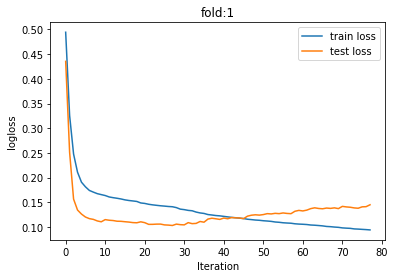

[I 2021-12-27 16:22:42,638] A new study created in memory with name: no-name-40a0ba33-a14b-4bb5-a43e-57ce49f05235


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:42,949] Trial 0 finished with value: 0.1407062059614464 and parameters: {'learning_rate': 0.2979705344345628, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 0 with value: 0.1407062059614464.
[I 2021-12-27 16:22:43,027] Trial 1 finished with value: 0.13463842859370312 and parameters: {'learning_rate': 0.861589497484195, 'num_leaves': 18, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.13463842859370312.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0917939	Test's rmse: 0.140706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.151285	Test's rmse: 0.134638
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:43,188] Trial 2 finished with value: 0.12425958651190454 and parameters: {'learning_rate': 0.6232360350085951, 'num_leaves': 41, 'tree_learner': 'data'}. Best is trial 2 with value: 0.12425958651190454.
[I 2021-12-27 16:22:43,320] Trial 3 finished with value: 0.12773111292898143 and parameters: {'learning_rate': 0.6835352886891323, 'num_leaves': 37, 'tree_learner': 'data'}. Best is trial 2 with value: 0.12425958651190454.


Early stopping, best iteration is:
[25]	Train's rmse: 0.149876	Test's rmse: 0.12426
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	Train's rmse: 0.158101	Test's rmse: 0.127731
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, bes

[I 2021-12-27 16:22:43,405] Trial 4 finished with value: 0.13001347937836724 and parameters: {'learning_rate': 0.44586611361048045, 'num_leaves': 15, 'tree_learner': 'data'}. Best is trial 2 with value: 0.12425958651190454.
[I 2021-12-27 16:22:43,551] Trial 5 finished with value: 0.11786081451359401 and parameters: {'learning_rate': 0.778699073288406, 'num_leaves': 43, 'tree_learner': 'data'}. Best is trial 5 with value: 0.11786081451359401.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.154948	Test's rmse: 0.117861
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:43,767] Trial 6 finished with value: 0.14215414702896673 and parameters: {'learning_rate': 0.26003848582644085, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 5 with value: 0.11786081451359401.
[I 2021-12-27 16:22:43,834] Trial 7 finished with value: 0.1333215889749752 and parameters: {'learning_rate': 0.868752601831233, 'num_leaves': 13, 'tree_learner': 'voting'}. Best is trial 5 with value: 0.11786081451359401.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.117982	Test's rmse: 0.142154
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	Train's rmse: 0.120274	Test's rmse: 0.133322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Earl

[I 2021-12-27 16:22:43,951] Trial 8 finished with value: 0.12203940777863719 and parameters: {'learning_rate': 0.6623752220562652, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 5 with value: 0.11786081451359401.
[I 2021-12-27 16:22:44,055] Trial 9 finished with value: 0.12523014975624175 and parameters: {'learning_rate': 0.8373365331149919, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 5 with value: 0.11786081451359401.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	Train's rmse: 0.160183	Test's rmse: 0.12523
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:44,205] Trial 10 finished with value: 0.12221307977526273 and parameters: {'learning_rate': 0.4912332640400179, 'num_leaves': 24, 'tree_learner': 'feature'}. Best is trial 5 with value: 0.11786081451359401.
[I 2021-12-27 16:22:44,316] Trial 11 finished with value: 0.13170358620923897 and parameters: {'learning_rate': 0.9910375267497196, 'num_leaves': 29, 'tree_learner': 'voting'}. Best is trial 5 with value: 0.11786081451359401.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136843	Test's rmse: 0.122213
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.158735	Test's rmse: 0.131704
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early

[I 2021-12-27 16:22:44,405] Trial 12 finished with value: 0.1514270721842119 and parameters: {'learning_rate': 0.7285704027982042, 'num_leaves': 5, 'tree_learner': 'feature'}. Best is trial 5 with value: 0.11786081451359401.
[I 2021-12-27 16:22:44,583] Trial 13 finished with value: 0.13100469250268976 and parameters: {'learning_rate': 0.5548542708761347, 'num_leaves': 48, 'tree_learner': 'data'}. Best is trial 5 with value: 0.11786081451359401.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.143661	Test's rmse: 0.131005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:44,766] Trial 14 finished with value: 0.1362009362697704 and parameters: {'learning_rate': 0.13716006383895085, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 5 with value: 0.11786081451359401.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141737	Test's rmse: 0.136201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.157765	Test's rmse: 0.112935


[I 2021-12-27 16:22:44,939] Trial 15 finished with value: 0.11293473408464653 and parameters: {'learning_rate': 0.7627227644950743, 'num_leaves': 44, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:45,115] Trial 16 finished with value: 0.13231418198195063 and parameters: {'learning_rate': 0.99274191042808, 'num_leaves': 44, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	Train's rmse: 0.151768	Test's rmse: 0.132314
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:45,284] Trial 17 finished with value: 0.11966537996523291 and parameters: {'learning_rate': 0.7734917513404946, 'num_leaves': 45, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:45,388] Trial 18 finished with value: 0.12905758446101012 and parameters: {'learning_rate': 0.5795594833165962, 'num_leaves': 24, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[16]	Train's rmse: 0.154847	Test's rmse: 0.119665
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	Train's rmse: 0.154992	Test's rmse: 0.129058
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:45,591] Trial 19 finished with value: 0.1323840255597523 and parameters: {'learning_rate': 0.41862843538018224, 'num_leaves': 38, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[39]	Train's rmse: 0.142122	Test's rmse: 0.132384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:45,794] Trial 20 finished with value: 0.11813338395822894 and parameters: {'learning_rate': 0.7799748437064135, 'num_leaves': 44, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[16]	Train's rmse: 0.15488	Test's rmse: 0.118133
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:46,009] Trial 21 finished with value: 0.11760578953519463 and parameters: {'learning_rate': 0.7703996497452739, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:46,180] Trial 22 finished with value: 0.12949253870800936 and parameters: {'learning_rate': 0.912309657728877, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[16]	Train's rmse: 0.155339	Test's rmse: 0.117606
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	Train's rmse: 0.161795	Test's rmse: 0.129493


[I 2021-12-27 16:22:46,349] Trial 23 finished with value: 0.11530503544438264 and parameters: {'learning_rate': 0.7444148597193838, 'num_leaves': 41, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.159403	Test's rmse: 0.115305
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:46,539] Trial 24 finished with value: 0.1269847195185377 and parameters: {'learning_rate': 0.7035582823035408, 'num_leaves': 46, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[17]	Train's rmse: 0.157092	Test's rmse: 0.126985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.148406	Test's rmse: 0.120208


[I 2021-12-27 16:22:46,750] Trial 25 finished with value: 0.12020837752983882 and parameters: {'learning_rate': 0.9237562539557627, 'num_leaves': 39, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:46,903] Trial 26 finished with value: 0.12634815552516676 and parameters: {'learning_rate': 0.6255901008213995, 'num_leaves': 34, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.161011	Test's rmse: 0.126348
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:47,090] Trial 27 finished with value: 0.12926883119165208 and parameters: {'learning_rate': 0.8220475015647036, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[10]	Train's rmse: 0.168606	Test's rmse: 0.129269
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:47,284] Trial 28 finished with value: 0.12978837885105265 and parameters: {'learning_rate': 0.7326660983178542, 'num_leaves': 47, 'tree_learner': 'feature'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[17]	Train's rmse: 0.156843	Test's rmse: 0.129788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:47,531] Trial 29 finished with value: 0.1365862135896373 and parameters: {'learning_rate': 0.34901383536150155, 'num_leaves': 42, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[44]	Train's rmse: 0.149065	Test's rmse: 0.136586
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:47,738] Trial 30 finished with value: 0.13255644339141687 and parameters: {'learning_rate': 0.9246233471296312, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[10]	Train's rmse: 0.164619	Test's rmse: 0.132556
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.158503	Test's rmse: 0.113247


[I 2021-12-27 16:22:47,932] Trial 31 finished with value: 0.1132467423719509 and parameters: {'learning_rate': 0.7449681293305123, 'num_leaves': 42, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:48,121] Trial 32 finished with value: 0.12841402396110985 and parameters: {'learning_rate': 0.6338825211113063, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	Train's rmse: 0.140948	Test's rmse: 0.128414


[I 2021-12-27 16:22:48,280] Trial 33 finished with value: 0.12926937680692493 and parameters: {'learning_rate': 0.8100691645609177, 'num_leaves': 41, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	Train's rmse: 0.168045	Test's rmse: 0.129269
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:48,435] Trial 34 finished with value: 0.1250518488323528 and parameters: {'learning_rate': 0.7236994013574438, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[20]	Train's rmse: 0.153156	Test's rmse: 0.125052
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:48,621] Trial 35 finished with value: 0.12337344394724824 and parameters: {'learning_rate': 0.8774405909253327, 'num_leaves': 50, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[14]	Train's rmse: 0.159888	Test's rmse: 0.123373
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:48,863] Trial 36 finished with value: 0.1220318168899253 and parameters: {'learning_rate': 0.49934603496312485, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:48,994] Trial 37 finished with value: 0.1315470388591077 and parameters: {'learning_rate': 0.5930560305874755, 'num_leaves': 41, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[33]	Train's rmse: 0.140344	Test's rmse: 0.122032
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.158927	Test's rmse: 0.131547
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:49,158] Trial 38 finished with value: 0.12517290919423765 and parameters: {'learning_rate': 0.671921793204591, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:49,286] Trial 39 finished with value: 0.113399914476715 and parameters: {'learning_rate': 0.7696212404945756, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[15]	Train's rmse: 0.163388	Test's rmse: 0.125173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.157723	Test's rmse: 0.1134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:49,423] Trial 40 finished with value: 0.11748596148877954 and parameters: {'learning_rate': 0.6687489312388857, 'num_leaves': 26, 'tree_learner': 'serial'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:49,549] Trial 41 finished with value: 0.11825189213385003 and parameters: {'learning_rate': 0.6545948062373959, 'num_leaves': 25, 'tree_learner': 'serial'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[21]	Train's rmse: 0.154919	Test's rmse: 0.117486
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	Train's rmse: 0.15669	Test's rmse: 0.118252
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:49,677] Trial 42 finished with value: 0.11838848316471129 and parameters: {'learning_rate': 0.6991475070795753, 'num_leaves': 20, 'tree_learner': 'serial'}. Best is trial 15 with value: 0.11293473408464653.
[I 2021-12-27 16:22:49,795] Trial 43 finished with value: 0.1285336291798079 and parameters: {'learning_rate': 0.7541388043693732, 'num_leaves': 20, 'tree_learner': 'serial'}. Best is trial 15 with value: 0.11293473408464653.


Early stopping, best iteration is:
[17]	Train's rmse: 0.158769	Test's rmse: 0.118388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	Train's rmse: 0.144714	Test's rmse: 0.128534
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:49,935] Trial 44 finished with value: 0.11277713134401189 and parameters: {'learning_rate': 0.8336026480781311, 'num_leaves': 27, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:50,073] Trial 45 finished with value: 0.12459830983403025 and parameters: {'learning_rate': 0.8603871176237321, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[21]	Train's rmse: 0.12655	Test's rmse: 0.112777
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	Train's rmse: 0.157967	Test's rmse: 0.124598
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:50,220] Trial 46 finished with value: 0.1217634461775816 and parameters: {'learning_rate': 0.8098830252166347, 'num_leaves': 29, 'tree_learner': 'feature'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:50,304] Trial 47 finished with value: 0.13370948717372066 and parameters: {'learning_rate': 0.891036644847591, 'num_leaves': 16, 'tree_learner': 'data'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[28]	Train's rmse: 0.132704	Test's rmse: 0.121763
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.173069	Test's rmse: 0.133709
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:50,427] Trial 48 finished with value: 0.13426189631494811 and parameters: {'learning_rate': 0.9389065501690411, 'num_leaves': 21, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:50,561] Trial 49 finished with value: 0.12484819833565945 and parameters: {'learning_rate': 0.9616649215338837, 'num_leaves': 27, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[8]	Train's rmse: 0.170802	Test's rmse: 0.134262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.160281	Test's rmse: 0.124848
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:50,623] Trial 50 finished with value: 0.14757383473035396 and parameters: {'learning_rate': 0.8508312599619721, 'num_leaves': 12, 'tree_learner': 'data'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:50,746] Trial 51 finished with value: 0.11827791792470987 and parameters: {'learning_rate': 0.7935966489809788, 'num_leaves': 23, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[11]	Train's rmse: 0.155531	Test's rmse: 0.147574
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	Train's rmse: 0.160988	Test's rmse: 0.118278
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:50,871] Trial 52 finished with value: 0.11705549175995708 and parameters: {'learning_rate': 0.738043739624357, 'num_leaves': 26, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:51,001] Trial 53 finished with value: 0.1281179418138006 and parameters: {'learning_rate': 0.8431297352079281, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[21]	Train's rmse: 0.149496	Test's rmse: 0.117055
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	Train's rmse: 0.163459	Test's rmse: 0.128118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:51,116] Trial 54 finished with value: 0.11885930073386515 and parameters: {'learning_rate': 0.7380746933581477, 'num_leaves': 28, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:51,277] Trial 55 finished with value: 0.1280161697046887 and parameters: {'learning_rate': 0.7028151913740502, 'num_leaves': 36, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[15]	Train's rmse: 0.158051	Test's rmse: 0.118859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	Train's rmse: 0.157252	Test's rmse: 0.128016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:51,400] Trial 56 finished with value: 0.13593973363192635 and parameters: {'learning_rate': 0.7834099804314406, 'num_leaves': 22, 'tree_learner': 'data'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:51,568] Trial 57 finished with value: 0.12491172110137805 and parameters: {'learning_rate': 0.5159242556320527, 'num_leaves': 31, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[14]	Train's rmse: 0.160996	Test's rmse: 0.13594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	Train's rmse: 0.143388	Test's rmse: 0.124912


[I 2021-12-27 16:22:51,742] Trial 58 finished with value: 0.11528016776757179 and parameters: {'learning_rate': 0.7553323712409123, 'num_leaves': 43, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.15799	Test's rmse: 0.11528
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:52,032] Trial 59 finished with value: 0.14075899029366068 and parameters: {'learning_rate': 0.11571385840747667, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149917	Test's rmse: 0.140759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:52,257] Trial 60 finished with value: 0.123278098815594 and parameters: {'learning_rate': 0.6026178866717278, 'num_leaves': 43, 'tree_learner': 'feature'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:52,412] Trial 61 finished with value: 0.11506787050141455 and parameters: {'learning_rate': 0.7480012888231714, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[27]	Train's rmse: 0.143603	Test's rmse: 0.123278
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.159381	Test's rmse: 0.115068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-12-27 16:22:52,597] Trial 62 finished with value: 0.11427954801596472 and parameters: {'learning_rate': 0.7602190397417673, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	Train's rmse: 0.152996	Test's rmse: 0.11428
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:52,780] Trial 63 finished with value: 0.12018303277562678 and parameters: {'learning_rate': 0.8047669582846658, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:52,942] Trial 64 finished with value: 0.11616414975104458 and parameters: {'learning_rate': 0.7652276181350471, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[18]	Train's rmse: 0.153231	Test's rmse: 0.120183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	Train's rmse: 0.154763	Test's rmse: 0.116164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-12-27 16:22:53,137] Trial 65 finished with value: 0.12615195385787262 and parameters: {'learning_rate': 0.8985246502532934, 'num_leaves': 43, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	Train's rmse: 0.16052	Test's rmse: 0.126152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:53,407] Trial 66 finished with value: 0.13858275726482394 and parameters: {'learning_rate': 0.20151693481990696, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14037	Test's rmse: 0.138583
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.155039	Test's rmse: 0.123903


[I 2021-12-27 16:22:53,576] Trial 67 finished with value: 0.12390253695962751 and parameters: {'learning_rate': 0.8210265894779499, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:53,743] Trial 68 finished with value: 0.12784439286061197 and parameters: {'learning_rate': 0.6979655126330523, 'num_leaves': 45, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	Train's rmse: 0.15749	Test's rmse: 0.127844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:53,975] Trial 69 finished with value: 0.12837368371051677 and parameters: {'learning_rate': 0.6399165438650414, 'num_leaves': 40, 'tree_learner': 'data'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[30]	Train's rmse: 0.13012	Test's rmse: 0.128374
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.168191	Test's rmse: 0.129557


[I 2021-12-27 16:22:54,155] Trial 70 finished with value: 0.12955731287499034 and parameters: {'learning_rate': 0.8320180114679984, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:54,349] Trial 71 finished with value: 0.11389539002307376 and parameters: {'learning_rate': 0.7636292572500443, 'num_leaves': 42, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.157567	Test's rmse: 0.113895
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-12-27 16:22:54,553] Trial 72 finished with value: 0.11736669796561273 and parameters: {'learning_rate': 0.7719828897143309, 'num_leaves': 42, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.154919	Test's rmse: 0.117367


[I 2021-12-27 16:22:54,752] Trial 73 finished with value: 0.1248621437688727 and parameters: {'learning_rate': 0.7184990374167974, 'num_leaves': 44, 'tree_learner': 'data'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	Train's rmse: 0.15333	Test's rmse: 0.124862


[I 2021-12-27 16:22:54,898] Trial 74 finished with value: 0.11341548662857108 and parameters: {'learning_rate': 0.755868807771214, 'num_leaves': 37, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.157858	Test's rmse: 0.113415
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:55,054] Trial 75 finished with value: 0.12732304136833278 and parameters: {'learning_rate': 0.6854486703055502, 'num_leaves': 37, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:55,216] Trial 76 finished with value: 0.12692794541076285 and parameters: {'learning_rate': 0.8662068406831511, 'num_leaves': 40, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[17]	Train's rmse: 0.157881	Test's rmse: 0.127323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	Train's rmse: 0.16171	Test's rmse: 0.126928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:55,362] Trial 77 finished with value: 0.12045477151446227 and parameters: {'learning_rate': 0.7867067264353457, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.


Early stopping, best iteration is:
[16]	Train's rmse: 0.153029	Test's rmse: 0.120455
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.162911	Test's rmse: 0.122386


[I 2021-12-27 16:22:55,552] Trial 78 finished with value: 0.12238585315658662 and parameters: {'learning_rate': 0.5634714440312429, 'num_leaves': 42, 'tree_learner': 'voting'}. Best is trial 44 with value: 0.11277713134401189.
[I 2021-12-27 16:22:55,712] Trial 79 finished with value: 0.11320295173073491 and parameters: {'learning_rate': 0.7186170492265543, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 44 with value: 0.11277713134401189.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	Train's rmse: 0.153534	Test's rmse: 0.113203
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:55,868] Trial 80 finished with value: 0.10749593802589563 and parameters: {'learning_rate': 0.723383566622474, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.
[I 2021-12-27 16:22:56,023] Trial 81 finished with value: 0.1156280958378486 and parameters: {'learning_rate': 0.7104138337407562, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[22]	Train's rmse: 0.149332	Test's rmse: 0.107496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.157402	Test's rmse: 0.115628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-12-27 16:22:56,177] Trial 82 finished with value: 0.12107011919633127 and parameters: {'learning_rate': 0.7989465296774588, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	Train's rmse: 0.152977	Test's rmse: 0.12107
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:56,353] Trial 83 finished with value: 0.12995972673425804 and parameters: {'learning_rate': 0.82802756750284, 'num_leaves': 35, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[12]	Train's rmse: 0.165013	Test's rmse: 0.12996
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:56,594] Trial 84 finished with value: 0.1181010080810937 and parameters: {'learning_rate': 0.6642404416348314, 'num_leaves': 28, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[17]	Train's rmse: 0.159929	Test's rmse: 0.118101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:57,003] Trial 85 finished with value: 0.13449611139495368 and parameters: {'learning_rate': 0.4285222129595001, 'num_leaves': 38, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[37]	Train's rmse: 0.144555	Test's rmse: 0.134496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:57,230] Trial 86 finished with value: 0.11566042312038466 and parameters: {'learning_rate': 0.7204143969668874, 'num_leaves': 25, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[17]	Train's rmse: 0.157761	Test's rmse: 0.11566
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:57,507] Trial 87 finished with value: 0.1269822417322277 and parameters: {'learning_rate': 0.685571090584353, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[17]	Train's rmse: 0.158138	Test's rmse: 0.126982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:57,805] Trial 88 finished with value: 0.11507315763513794 and parameters: {'learning_rate': 0.7692517678726754, 'num_leaves': 36, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[17]	Train's rmse: 0.154939	Test's rmse: 0.115073
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:58,120] Trial 89 finished with value: 0.12407487213176958 and parameters: {'learning_rate': 0.6090308730586219, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[28]	Train's rmse: 0.143439	Test's rmse: 0.124075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:58,372] Trial 90 finished with value: 0.12258597542279767 and parameters: {'learning_rate': 0.8844496156431635, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[8]	Train's rmse: 0.168443	Test's rmse: 0.122586
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:58,733] Trial 91 finished with value: 0.11650737648037753 and parameters: {'learning_rate': 0.7470499075035039, 'num_leaves': 40, 'tree_learner': 'data'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[26]	Train's rmse: 0.142309	Test's rmse: 0.116507
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:59,053] Trial 92 finished with value: 0.10861826914583159 and parameters: {'learning_rate': 0.7342000296164439, 'num_leaves': 37, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[22]	Train's rmse: 0.148675	Test's rmse: 0.108618
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:59,357] Trial 93 finished with value: 0.12957028780854904 and parameters: {'learning_rate': 0.7300105178083541, 'num_leaves': 37, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[17]	Train's rmse: 0.157005	Test's rmse: 0.12957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:59,618] Trial 94 finished with value: 0.11823008329240497 and parameters: {'learning_rate': 0.7909939079557516, 'num_leaves': 32, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[15]	Train's rmse: 0.15722	Test's rmse: 0.11823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:22:59,830] Trial 95 finished with value: 0.12121373929333977 and parameters: {'learning_rate': 0.6420316745415114, 'num_leaves': 29, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[18]	Train's rmse: 0.160161	Test's rmse: 0.121214
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:00,043] Trial 96 finished with value: 0.12719330534620785 and parameters: {'learning_rate': 0.8083771884855344, 'num_leaves': 34, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[6]	Train's rmse: 0.184776	Test's rmse: 0.127193
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:00,277] Trial 97 finished with value: 0.11324751631264654 and parameters: {'learning_rate': 0.7575945661189829, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[19]	Train's rmse: 0.153294	Test's rmse: 0.113248
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:00,515] Trial 98 finished with value: 0.11527543041914724 and parameters: {'learning_rate': 0.8521767236675343, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[29]	Train's rmse: 0.110066	Test's rmse: 0.115275
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:00,722] Trial 99 finished with value: 0.11537706011218983 and parameters: {'learning_rate': 0.6974553027608681, 'num_leaves': 25, 'tree_learner': 'voting'}. Best is trial 80 with value: 0.10749593802589563.


Early stopping, best iteration is:
[21]	Train's rmse: 0.153892	Test's rmse: 0.115377
{'learning_rate': 0.723383566622474, 'num_leaves': 33, 'tree_learner': 'data'}
{'learning_rate': 0.723383566622474, 'num_leaves': 33, 'tree_learner': 'data', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	Train's rmse: 0.149332	Test's rmse: 0.107496


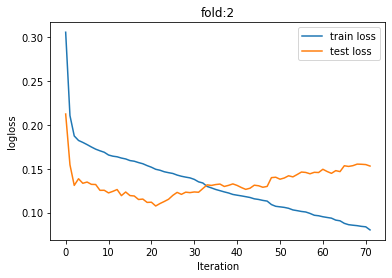

[I 2021-12-27 16:23:01,214] A new study created in memory with name: no-name-600d3cfd-bb09-485c-aa33-293f9debdf75
[I 2021-12-27 16:23:01,374] Trial 0 finished with value: 0.023273978758332682 and parameters: {'learning_rate': 0.20765510304548548, 'num_leaves': 9, 'tree_learner': 'data'}. Best is trial 0 with value: 0.023273978758332682.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	Train's rmse: 0.162744	Test's rmse: 0.023274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:01,542] Trial 1 finished with value: 0.026493111760182632 and parameters: {'learning_rate': 0.6955521364524527, 'num_leaves': 20, 'tree_learner': 'data'}. Best is trial 0 with value: 0.023273978758332682.
[I 2021-12-27 16:23:01,713] Trial 2 finished with value: 0.026590964766617427 and parameters: {'learning_rate': 0.6982380155127281, 'num_leaves': 27, 'tree_learner': 'data'}. Best is trial 0 with value: 0.023273978758332682.


Early stopping, best iteration is:
[10]	Train's rmse: 0.165241	Test's rmse: 0.0264931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.173212	Test's rmse: 0.026591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:02,029] Trial 3 finished with value: 0.02325154852888797 and parameters: {'learning_rate': 0.5140594685341867, 'num_leaves': 46, 'tree_learner': 'data'}. Best is trial 3 with value: 0.02325154852888797.


Early stopping, best iteration is:
[10]	Train's rmse: 0.160577	Test's rmse: 0.0232515
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:02,251] Trial 4 finished with value: 0.031244568534553215 and parameters: {'learning_rate': 0.9020439854837975, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 3 with value: 0.02325154852888797.
[I 2021-12-27 16:23:02,338] Trial 5 finished with value: 0.039925417530635804 and parameters: {'learning_rate': 0.39443637626866, 'num_leaves': 6, 'tree_learner': 'feature'}. Best is trial 3 with value: 0.02325154852888797.
[I 2021-12-27 16:23:02,425] Trial 6 finished with value: 0.03465930995473229 and parameters: {'learning_rate': 0.5558265355326605, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 3 with value: 0.02325154852888797.


Early stopping, best iteration is:
[2]	Train's rmse: 0.193778	Test's rmse: 0.0312446
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	Train's rmse: 0.138833	Test's rmse: 0.0399254
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[Li

[I 2021-12-27 16:23:02,568] Trial 7 finished with value: 0.02957293632272744 and parameters: {'learning_rate': 0.47640194206904585, 'num_leaves': 23, 'tree_learner': 'voting'}. Best is trial 3 with value: 0.02325154852888797.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.174824	Test's rmse: 0.0295729
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:02,802] Trial 8 finished with value: 0.0218563832810307 and parameters: {'learning_rate': 0.23162344439430566, 'num_leaves': 34, 'tree_learner': 'voting'}. Best is trial 8 with value: 0.0218563832810307.


Early stopping, best iteration is:
[20]	Train's rmse: 0.168562	Test's rmse: 0.0218564
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:03,005] Trial 9 finished with value: 0.022165469252533137 and parameters: {'learning_rate': 0.1355971715513618, 'num_leaves': 21, 'tree_learner': 'voting'}. Best is trial 8 with value: 0.0218563832810307.


Early stopping, best iteration is:
[29]	Train's rmse: 0.168603	Test's rmse: 0.0221655
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:03,306] Trial 10 finished with value: 0.023963383682300964 and parameters: {'learning_rate': 0.295756284317756, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 8 with value: 0.0218563832810307.


Early stopping, best iteration is:
[17]	Train's rmse: 0.174843	Test's rmse: 0.0239634
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:03,665] Trial 11 finished with value: 0.022107916759179662 and parameters: {'learning_rate': 0.10873272354224335, 'num_leaves': 33, 'tree_learner': 'voting'}. Best is trial 8 with value: 0.0218563832810307.


Early stopping, best iteration is:
[44]	Train's rmse: 0.163654	Test's rmse: 0.0221079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:04,019] Trial 12 finished with value: 0.020868091107132475 and parameters: {'learning_rate': 0.10180240007144567, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[46]	Train's rmse: 0.164654	Test's rmse: 0.0208681
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:04,347] Trial 13 finished with value: 0.023930063556336912 and parameters: {'learning_rate': 0.2890142391033489, 'num_leaves': 46, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[13]	Train's rmse: 0.169153	Test's rmse: 0.0239301
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:04,597] Trial 14 finished with value: 0.025912841741850257 and parameters: {'learning_rate': 0.2297500496425574, 'num_leaves': 32, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[18]	Train's rmse: 0.163421	Test's rmse: 0.0259128
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:04,873] Trial 15 finished with value: 0.02804789551116757 and parameters: {'learning_rate': 0.37577471765170267, 'num_leaves': 41, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[11]	Train's rmse: 0.167378	Test's rmse: 0.0280479
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:05,177] Trial 16 finished with value: 0.0220932146367158 and parameters: {'learning_rate': 0.10611230532041943, 'num_leaves': 31, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[40]	Train's rmse: 0.166491	Test's rmse: 0.0220932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:05,533] Trial 17 finished with value: 0.02128820789607295 and parameters: {'learning_rate': 0.22210549107589744, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[19]	Train's rmse: 0.166152	Test's rmse: 0.0212882
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:05,848] Trial 18 finished with value: 0.026046935564147937 and parameters: {'learning_rate': 0.37703734448197723, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.
[I 2021-12-27 16:23:05,981] Trial 19 finished with value: 0.03250141153281227 and parameters: {'learning_rate': 0.9170048243004578, 'num_leaves': 14, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[16]	Train's rmse: 0.164615	Test's rmse: 0.0260469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.165605	Test's rmse: 0.0325014
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:06,259] Trial 20 finished with value: 0.025934129591497955 and parameters: {'learning_rate': 0.6768680520207438, 'num_leaves': 43, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[4]	Train's rmse: 0.180786	Test's rmse: 0.0259341
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:06,559] Trial 21 finished with value: 0.02112087336772345 and parameters: {'learning_rate': 0.2058554794954884, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[22]	Train's rmse: 0.166363	Test's rmse: 0.0211209
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:06,929] Trial 22 finished with value: 0.021548378013716143 and parameters: {'learning_rate': 0.21232924950166265, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[20]	Train's rmse: 0.169234	Test's rmse: 0.0215484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:07,153] Trial 23 finished with value: 0.02473460266713057 and parameters: {'learning_rate': 0.30537002264027124, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020868091107132475.


Early stopping, best iteration is:
[14]	Train's rmse: 0.169889	Test's rmse: 0.0247346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:07,449] Trial 24 finished with value: 0.020802969532363515 and parameters: {'learning_rate': 0.16925180616783098, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 24 with value: 0.020802969532363515.


Early stopping, best iteration is:
[27]	Train's rmse: 0.167538	Test's rmse: 0.020803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:07,782] Trial 25 finished with value: 0.023741206914690123 and parameters: {'learning_rate': 0.1509086077456351, 'num_leaves': 36, 'tree_learner': 'serial'}. Best is trial 24 with value: 0.020802969532363515.


Early stopping, best iteration is:
[26]	Train's rmse: 0.1672	Test's rmse: 0.0237412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:08,068] Trial 26 finished with value: 0.02130202440358876 and parameters: {'learning_rate': 0.1684358844212746, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 24 with value: 0.020802969532363515.


Early stopping, best iteration is:
[29]	Train's rmse: 0.1736	Test's rmse: 0.021302
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:08,326] Trial 27 finished with value: 0.02078244450868839 and parameters: {'learning_rate': 0.43612169629680786, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[9]	Train's rmse: 0.16998	Test's rmse: 0.0207824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:08,579] Trial 28 finished with value: 0.028509643306802508 and parameters: {'learning_rate': 0.8193745941990029, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[5]	Train's rmse: 0.181497	Test's rmse: 0.0285096
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:08,811] Trial 29 finished with value: 0.02584814321104962 and parameters: {'learning_rate': 0.6156887601319012, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[8]	Train's rmse: 0.166051	Test's rmse: 0.0258481
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:09,082] Trial 30 finished with value: 0.02766624027340042 and parameters: {'learning_rate': 0.4478855865864253, 'num_leaves': 44, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[9]	Train's rmse: 0.168326	Test's rmse: 0.0276662
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:09,361] Trial 31 finished with value: 0.022954965521181984 and parameters: {'learning_rate': 0.3065318475696055, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[14]	Train's rmse: 0.16502	Test's rmse: 0.022955
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:09,719] Trial 32 finished with value: 0.0224233728384791 and parameters: {'learning_rate': 0.17856748651287227, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[27]	Train's rmse: 0.16184	Test's rmse: 0.0224234
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 0.169583	Test's rmse: 0.0237261


[I 2021-12-27 16:23:09,932] Trial 33 finished with value: 0.023726116119170013 and parameters: {'learning_rate': 0.2668243960090811, 'num_leaves': 28, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:10,222] Trial 34 finished with value: 0.022382380402958972 and parameters: {'learning_rate': 0.43549348990472037, 'num_leaves': 40, 'tree_learner': 'feature'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[10]	Train's rmse: 0.168605	Test's rmse: 0.0223824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:10,455] Trial 35 finished with value: 0.024469039288834465 and parameters: {'learning_rate': 0.3449422453230468, 'num_leaves': 25, 'tree_learner': 'data'}. Best is trial 27 with value: 0.02078244450868839.
[I 2021-12-27 16:23:10,586] Trial 36 finished with value: 0.03232776679034261 and parameters: {'learning_rate': 0.7885706731352073, 'num_leaves': 14, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[17]	Train's rmse: 0.154693	Test's rmse: 0.024469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.169995	Test's rmse: 0.0323278
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:10,819] Trial 37 finished with value: 0.0216923431443874 and parameters: {'learning_rate': 0.5524664379274691, 'num_leaves': 29, 'tree_learner': 'data'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[7]	Train's rmse: 0.17478	Test's rmse: 0.0216923
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:11,162] Trial 38 finished with value: 0.02166018125819199 and parameters: {'learning_rate': 0.18056027288313758, 'num_leaves': 36, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[24]	Train's rmse: 0.169099	Test's rmse: 0.0216602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:11,490] Trial 39 finished with value: 0.02647932852475202 and parameters: {'learning_rate': 0.5032437194213003, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[8]	Train's rmse: 0.167645	Test's rmse: 0.0264793
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:11,891] Trial 40 finished with value: 0.02176284970128963 and parameters: {'learning_rate': 0.10331014829549645, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[45]	Train's rmse: 0.16494	Test's rmse: 0.0217629
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:12,258] Trial 41 finished with value: 0.024739066904008965 and parameters: {'learning_rate': 0.26259214179949275, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[21]	Train's rmse: 0.154143	Test's rmse: 0.0247391
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:12,671] Trial 42 finished with value: 0.021961574691580214 and parameters: {'learning_rate': 0.20663513168084338, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[23]	Train's rmse: 0.164649	Test's rmse: 0.0219616
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:12,969] Trial 43 finished with value: 0.023717542409972425 and parameters: {'learning_rate': 0.24420262639929413, 'num_leaves': 38, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[21]	Train's rmse: 0.163824	Test's rmse: 0.0237175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:13,218] Trial 44 finished with value: 0.022879362221206897 and parameters: {'learning_rate': 0.33756915440103524, 'num_leaves': 34, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[15]	Train's rmse: 0.162318	Test's rmse: 0.0228794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:13,585] Trial 45 finished with value: 0.022151214804556806 and parameters: {'learning_rate': 0.14499284807581056, 'num_leaves': 41, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[29]	Train's rmse: 0.167817	Test's rmse: 0.0221512
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	Train's rmse: 0.169834	Test's rmse: 0.0217257


[I 2021-12-27 16:23:13,778] Trial 46 finished with value: 0.02172564847495537 and parameters: {'learning_rate': 0.18700124084945485, 'num_leaves': 23, 'tree_learner': 'data'}. Best is trial 27 with value: 0.02078244450868839.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:14,020] Trial 47 finished with value: 0.02469125360190063 and parameters: {'learning_rate': 0.4287003113520362, 'num_leaves': 31, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[9]	Train's rmse: 0.170058	Test's rmse: 0.0246913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:14,440] Trial 48 finished with value: 0.02085491336023865 and parameters: {'learning_rate': 0.13039864164211237, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[33]	Train's rmse: 0.167286	Test's rmse: 0.0208549
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:14,891] Trial 49 finished with value: 0.0211049511813424 and parameters: {'learning_rate': 0.10995360650544653, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 27 with value: 0.02078244450868839.


Early stopping, best iteration is:
[41]	Train's rmse: 0.164292	Test's rmse: 0.021105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:15,286] Trial 50 finished with value: 0.020420414122997988 and parameters: {'learning_rate': 0.13108976893663318, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[34]	Train's rmse: 0.168006	Test's rmse: 0.0204204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:15,557] Trial 51 finished with value: 0.025154264934133516 and parameters: {'learning_rate': 0.9799225307341667, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[7]	Train's rmse: 0.177793	Test's rmse: 0.0251543
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:15,923] Trial 52 finished with value: 0.02096205170343346 and parameters: {'learning_rate': 0.14101891946401063, 'num_leaves': 44, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[31]	Train's rmse: 0.166013	Test's rmse: 0.0209621
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:16,323] Trial 53 finished with value: 0.020624269225745707 and parameters: {'learning_rate': 0.13560757251683472, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[29]	Train's rmse: 0.168609	Test's rmse: 0.0206243
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:16,723] Trial 54 finished with value: 0.02222794319943891 and parameters: {'learning_rate': 0.13211437627143, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[30]	Train's rmse: 0.169783	Test's rmse: 0.0222279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:16,947] Trial 55 finished with value: 0.02932222739261083 and parameters: {'learning_rate': 0.5968485495968481, 'num_leaves': 40, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[5]	Train's rmse: 0.173794	Test's rmse: 0.0293222
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:17,291] Trial 56 finished with value: 0.02123676173702446 and parameters: {'learning_rate': 0.160415823969227, 'num_leaves': 43, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[28]	Train's rmse: 0.166252	Test's rmse: 0.0212368
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:17,572] Trial 57 finished with value: 0.02434295020931479 and parameters: {'learning_rate': 0.2626905648936132, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[21]	Train's rmse: 0.154136	Test's rmse: 0.024343
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:18,028] Trial 58 finished with value: 0.021525890108685414 and parameters: {'learning_rate': 0.10420077545050974, 'num_leaves': 45, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[37]	Train's rmse: 0.173519	Test's rmse: 0.0215259
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:18,414] Trial 59 finished with value: 0.021824879832333586 and parameters: {'learning_rate': 0.23566535324180635, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[16]	Train's rmse: 0.169578	Test's rmse: 0.0218249
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:18,900] Trial 60 finished with value: 0.021295647519031805 and parameters: {'learning_rate': 0.19147864767887723, 'num_leaves': 41, 'tree_learner': 'feature'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[28]	Train's rmse: 0.164774	Test's rmse: 0.0212956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:19,362] Trial 61 finished with value: 0.02323397315669798 and parameters: {'learning_rate': 0.14168073448520932, 'num_leaves': 44, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[31]	Train's rmse: 0.164513	Test's rmse: 0.023234
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:19,854] Trial 62 finished with value: 0.021588438591058943 and parameters: {'learning_rate': 0.13304950134667826, 'num_leaves': 43, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[34]	Train's rmse: 0.165311	Test's rmse: 0.0215884
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:20,240] Trial 63 finished with value: 0.020881386493663074 and parameters: {'learning_rate': 0.1593742556160937, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[25]	Train's rmse: 0.166797	Test's rmse: 0.0208814
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:20,706] Trial 64 finished with value: 0.02084635481640051 and parameters: {'learning_rate': 0.1688406215641684, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[25]	Train's rmse: 0.166966	Test's rmse: 0.0208464
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:21,287] Trial 65 finished with value: 0.022867706478256557 and parameters: {'learning_rate': 0.20055113544459624, 'num_leaves': 40, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[22]	Train's rmse: 0.167353	Test's rmse: 0.0228677
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:21,591] Trial 66 finished with value: 0.024583771557596525 and parameters: {'learning_rate': 0.3333890289738325, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[14]	Train's rmse: 0.164058	Test's rmse: 0.0245838
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:21,991] Trial 67 finished with value: 0.021205983612689487 and parameters: {'learning_rate': 0.23467279018709997, 'num_leaves': 47, 'tree_learner': 'data'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[19]	Train's rmse: 0.166877	Test's rmse: 0.021206
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:22,460] Trial 68 finished with value: 0.0214060581465804 and parameters: {'learning_rate': 0.12336223174839782, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[38]	Train's rmse: 0.165031	Test's rmse: 0.0214061
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:22,748] Trial 69 finished with value: 0.02413621912972225 and parameters: {'learning_rate': 0.29311270593325506, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[13]	Train's rmse: 0.178837	Test's rmse: 0.0241362
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:22,981] Trial 70 finished with value: 0.02585709590367987 and parameters: {'learning_rate': 0.7428783484182717, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 50 with value: 0.020420414122997988.


Early stopping, best iteration is:
[3]	Train's rmse: 0.190009	Test's rmse: 0.0258571
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:23,352] Trial 71 finished with value: 0.01946861960634616 and parameters: {'learning_rate': 0.1691201673106029, 'num_leaves': 40, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[27]	Train's rmse: 0.165719	Test's rmse: 0.0194686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:23,673] Trial 72 finished with value: 0.02076569749643054 and parameters: {'learning_rate': 0.16964972768083225, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[28]	Train's rmse: 0.167625	Test's rmse: 0.0207657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:23,958] Trial 73 finished with value: 0.02122948539079294 and parameters: {'learning_rate': 0.1647686058981519, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[26]	Train's rmse: 0.165843	Test's rmse: 0.0212295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:24,301] Trial 74 finished with value: 0.023715653110201986 and parameters: {'learning_rate': 0.2171936466392036, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[19]	Train's rmse: 0.165502	Test's rmse: 0.0237157
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:24,597] Trial 75 finished with value: 0.021056877455494276 and parameters: {'learning_rate': 0.17871209130560084, 'num_leaves': 45, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[24]	Train's rmse: 0.16928	Test's rmse: 0.0210569
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:24,837] Trial 76 finished with value: 0.026088124559984792 and parameters: {'learning_rate': 0.2725709594237697, 'num_leaves': 36, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[13]	Train's rmse: 0.170231	Test's rmse: 0.0260881
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:25,124] Trial 77 finished with value: 0.02035579627471195 and parameters: {'learning_rate': 0.20870690685836596, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[25]	Train's rmse: 0.16444	Test's rmse: 0.0203558
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:25,369] Trial 78 finished with value: 0.022936207473807802 and parameters: {'learning_rate': 0.2444529043007803, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[19]	Train's rmse: 0.166968	Test's rmse: 0.0229362
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:25,704] Trial 79 finished with value: 0.020521872137237693 and parameters: {'learning_rate': 0.211333465473045, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[19]	Train's rmse: 0.167492	Test's rmse: 0.0205219
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:26,023] Trial 80 finished with value: 0.02195357991733273 and parameters: {'learning_rate': 0.2176690452493096, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[20]	Train's rmse: 0.167797	Test's rmse: 0.0219536
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:26,358] Trial 81 finished with value: 0.02116749027470344 and parameters: {'learning_rate': 0.19342059045983617, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[21]	Train's rmse: 0.170424	Test's rmse: 0.0211675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:26,734] Trial 82 finished with value: 0.01986350710165981 and parameters: {'learning_rate': 0.16373765518832756, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[28]	Train's rmse: 0.16739	Test's rmse: 0.0198635
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:27,295] Trial 83 finished with value: 0.022004903167467924 and parameters: {'learning_rate': 0.15318260085155747, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[31]	Train's rmse: 0.161579	Test's rmse: 0.0220049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:27,764] Trial 84 finished with value: 0.02241390271601557 and parameters: {'learning_rate': 0.2509462859255977, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[18]	Train's rmse: 0.163643	Test's rmse: 0.0224139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:28,059] Trial 85 finished with value: 0.030145561219287548 and parameters: {'learning_rate': 0.4007023188278033, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[14]	Train's rmse: 0.155093	Test's rmse: 0.0301456
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:28,346] Trial 86 finished with value: 0.024414045252745938 and parameters: {'learning_rate': 0.3145302969427297, 'num_leaves': 31, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[13]	Train's rmse: 0.168681	Test's rmse: 0.024414
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:28,640] Trial 87 finished with value: 0.030902849136819524 and parameters: {'learning_rate': 0.5130565548918125, 'num_leaves': 36, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[5]	Train's rmse: 0.178609	Test's rmse: 0.0309029
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:28,922] Trial 88 finished with value: 0.024844037376837328 and parameters: {'learning_rate': 0.2792451262094433, 'num_leaves': 29, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[20]	Train's rmse: 0.161247	Test's rmse: 0.024844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:29,224] Trial 89 finished with value: 0.024385611544487647 and parameters: {'learning_rate': 0.47753024499783386, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[9]	Train's rmse: 0.161214	Test's rmse: 0.0243856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:29,559] Trial 90 finished with value: 0.021817633611100687 and parameters: {'learning_rate': 0.11847719271710791, 'num_leaves': 27, 'tree_learner': 'data'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[38]	Train's rmse: 0.166552	Test's rmse: 0.0218176
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:29,945] Trial 91 finished with value: 0.02223720656203685 and parameters: {'learning_rate': 0.17215851458482506, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[26]	Train's rmse: 0.16792	Test's rmse: 0.0222372
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:30,392] Trial 92 finished with value: 0.022931700278238376 and parameters: {'learning_rate': 0.21204464744188856, 'num_leaves': 40, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[19]	Train's rmse: 0.167606	Test's rmse: 0.0229317
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:31,206] Trial 93 finished with value: 0.021807139379993335 and parameters: {'learning_rate': 0.18591284509443395, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[24]	Train's rmse: 0.164849	Test's rmse: 0.0218071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:31,829] Trial 94 finished with value: 0.022020311705012122 and parameters: {'learning_rate': 0.15288829192505027, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[25]	Train's rmse: 0.169263	Test's rmse: 0.0220203
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:32,189] Trial 95 finished with value: 0.02961353035891432 and parameters: {'learning_rate': 0.6432623897817598, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[4]	Train's rmse: 0.187712	Test's rmse: 0.0296135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:32,577] Trial 96 finished with value: 0.022181395437829106 and parameters: {'learning_rate': 0.12338998034483643, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[35]	Train's rmse: 0.164489	Test's rmse: 0.0221814
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:32,958] Trial 97 finished with value: 0.020044191219426872 and parameters: {'learning_rate': 0.20335477450323228, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.
[I 2021-12-27 16:23:33,094] Trial 98 finished with value: 0.03427475480018838 and parameters: {'learning_rate': 0.2248457217472556, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[20]	Train's rmse: 0.169586	Test's rmse: 0.0200442
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.172613	Test's rmse: 0.0342748
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:33,438] Trial 99 finished with value: 0.0220959837002175 and parameters: {'learning_rate': 0.20426729853334186, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 71 with value: 0.01946861960634616.


Early stopping, best iteration is:
[24]	Train's rmse: 0.161562	Test's rmse: 0.022096
{'learning_rate': 0.1691201673106029, 'num_leaves': 40, 'tree_learner': 'serial'}
{'learning_rate': 0.1691201673106029, 'num_leaves': 40, 'tree_learner': 'serial', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	Train's rmse: 0.165719	Test's rmse: 0.0194686


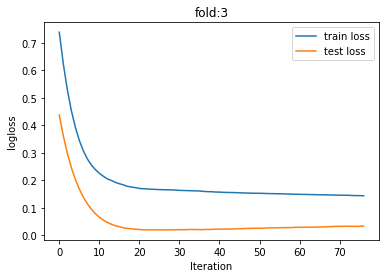

[I 2021-12-27 16:23:34,022] A new study created in memory with name: no-name-483d2789-70ef-472f-9d38-f6de2b084e72
[I 2021-12-27 16:23:34,194] Trial 0 finished with value: 0.3747862075923346 and parameters: {'learning_rate': 0.1666576629933066, 'num_leaves': 18, 'tree_learner': 'feature'}. Best is trial 0 with value: 0.3747862075923346.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	Train's rmse: 0.160415	Test's rmse: 0.374786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:34,419] Trial 1 finished with value: 0.36521370247742335 and parameters: {'learning_rate': 0.3210734397823005, 'num_leaves': 37, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.36521370247742335.


Early stopping, best iteration is:
[10]	Train's rmse: 0.153412	Test's rmse: 0.365214
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:34,713] Trial 2 finished with value: 0.3694937447834595 and parameters: {'learning_rate': 0.34382989446392287, 'num_leaves': 49, 'tree_learner': 'feature'}. Best is trial 1 with value: 0.36521370247742335.


Early stopping, best iteration is:
[10]	Train's rmse: 0.15205	Test's rmse: 0.369494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:34,909] Trial 3 finished with value: 0.37662963873044514 and parameters: {'learning_rate': 0.11583801818330541, 'num_leaves': 22, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.36521370247742335.


Early stopping, best iteration is:
[30]	Train's rmse: 0.155807	Test's rmse: 0.37663
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:35,111] Trial 4 finished with value: 0.3767814195357042 and parameters: {'learning_rate': 0.5478850624484968, 'num_leaves': 26, 'tree_learner': 'data'}. Best is trial 1 with value: 0.36521370247742335.


Early stopping, best iteration is:
[5]	Train's rmse: 0.160605	Test's rmse: 0.376781
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	Train's rmse: 0.184479	Test's rmse: 0.367957


[I 2021-12-27 16:23:35,297] Trial 5 finished with value: 0.36795710247643154 and parameters: {'learning_rate': 0.9958962314638299, 'num_leaves': 30, 'tree_learner': 'data'}. Best is trial 1 with value: 0.36521370247742335.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:35,551] Trial 6 finished with value: 0.3703947438791577 and parameters: {'learning_rate': 0.17325005411253472, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.36521370247742335.
[I 2021-12-27 16:23:35,688] Trial 7 finished with value: 0.38721706559828234 and parameters: {'learning_rate': 0.6096769160390674, 'num_leaves': 21, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.36521370247742335.


Early stopping, best iteration is:
[19]	Train's rmse: 0.155927	Test's rmse: 0.370395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.149953	Test's rmse: 0.387217
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:35,825] Trial 8 finished with value: 0.36035424629844404 and parameters: {'learning_rate': 0.4394767390958213, 'num_leaves': 17, 'tree_learner': 'serial'}. Best is trial 8 with value: 0.36035424629844404.


Early stopping, best iteration is:
[6]	Train's rmse: 0.161213	Test's rmse: 0.360354
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:36,112] Trial 9 finished with value: 0.373250814626678 and parameters: {'learning_rate': 0.33952122645929683, 'num_leaves': 47, 'tree_learner': 'data'}. Best is trial 8 with value: 0.36035424629844404.
[I 2021-12-27 16:23:36,195] Trial 10 finished with value: 0.3590849116568313 and parameters: {'learning_rate': 0.7222462120400597, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.3590849116568313.
[I 2021-12-27 16:23:36,277] Trial 11 finished with value: 0.36016329801816693 and parameters: {'learning_rate': 0.7393704747952059, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.3590849116568313.


Early stopping, best iteration is:
[10]	Train's rmse: 0.15308	Test's rmse: 0.373251
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.164074	Test's rmse: 0.359085
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:36,365] Trial 12 finished with value: 0.33641321670672764 and parameters: {'learning_rate': 0.7842953391240057, 'num_leaves': 6, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:36,449] Trial 13 finished with value: 0.34937383267084177 and parameters: {'learning_rate': 0.8151015550339349, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.170304	Test's rmse: 0.336413
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.171252	Test's rmse: 0.349374
[LightGBM] [Warning]

[I 2021-12-27 16:23:36,558] Trial 14 finished with value: 0.3803098956245152 and parameters: {'learning_rate': 0.9424825662447202, 'num_leaves': 11, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:36,663] Trial 15 finished with value: 0.356758069515452 and parameters: {'learning_rate': 0.8481400295908386, 'num_leaves': 12, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[5]	Train's rmse: 0.147991	Test's rmse: 0.38031
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.147027	Test's rmse: 0.356758
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best 

[I 2021-12-27 16:23:36,766] Trial 16 finished with value: 0.3566902249841196 and parameters: {'learning_rate': 0.7889133785167255, 'num_leaves': 12, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:36,837] Trial 17 finished with value: 0.37023680274952164 and parameters: {'learning_rate': 0.6147955899799968, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.194105	Test's rmse: 0.370237
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	Train's rmse: 0.108687	Test's rmse: 0.36467


[I 2021-12-27 16:23:36,969] Trial 18 finished with value: 0.364669848597981 and parameters: {'learning_rate': 0.8564687033168272, 'num_leaves': 13, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:37,208] Trial 19 finished with value: 0.37354225403222957 and parameters: {'learning_rate': 0.6696646063258481, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:37,364] Trial 20 finished with value: 0.373470153350396 and parameters: {'learning_rate': 0.8497561440475551, 'num_leaves': 25, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[8]	Train's rmse: 0.143913	Test's rmse: 0.373542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.171886	Test's rmse: 0.37347
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:37,458] Trial 21 finished with value: 0.35915753075794554 and parameters: {'learning_rate': 0.7734970110808856, 'num_leaves': 10, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[5]	Train's rmse: 0.157949	Test's rmse: 0.359158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:37,680] Trial 22 finished with value: 0.36859127988181456 and parameters: {'learning_rate': 0.8987905564000617, 'num_leaves': 16, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:37,822] Trial 23 finished with value: 0.39158946002804346 and parameters: {'learning_rate': 0.7887161524303338, 'num_leaves': 9, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0433243	Test's rmse: 0.368591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0530215	Test's rmse: 0.391589
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-12-27 16:23:38,005] Trial 24 finished with value: 0.37120618944729167 and parameters: {'learning_rate': 0.5077921222547828, 'num_leaves': 15, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.151534	Test's rmse: 0.371206
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:38,093] Trial 25 finished with value: 0.33987862388058704 and parameters: {'learning_rate': 0.6475426376403322, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:38,166] Trial 26 finished with value: 0.351036732220442 and parameters: {'learning_rate': 0.6516109983115131, 'num_leaves': 5, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:38,254] Trial 27 finished with value: 0.35311380457106467 and parameters: {'learning_rate': 0.6847033772060883, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[4]	Train's rmse: 0.190013	Test's rmse: 0.339879
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.178484	Test's rmse: 0.351037
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:38,394] Trial 28 finished with value: 0.3631801369838645 and parameters: {'learning_rate': 0.4689260669967851, 'num_leaves': 21, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.15264	Test's rmse: 0.36318
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:38,531] Trial 29 finished with value: 0.3633239469844643 and parameters: {'learning_rate': 0.5958649160369325, 'num_leaves': 19, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:38,636] Trial 30 finished with value: 0.3898745972695139 and parameters: {'learning_rate': 0.9354779462563039, 'num_leaves': 14, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:38,691] Trial 31 finished with value: 0.35686198020311133 and parameters: {'learning_rate': 0.6735542916835991, 'num_leaves': 5, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[5]	Train's rmse: 0.156686	Test's rmse: 0.363324
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	Train's rmse: 0.196366	Test's rmse: 0.389875
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:38,816] Trial 32 finished with value: 0.3578951814501772 and parameters: {'learning_rate': 0.6393408424815399, 'num_leaves': 9, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:38,894] Trial 33 finished with value: 0.36236399176250206 and parameters: {'learning_rate': 0.7194300413904898, 'num_leaves': 5, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[6]	Train's rmse: 0.161544	Test's rmse: 0.357895
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.167686	Test's rmse: 0.362364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:38,982] Trial 34 finished with value: 0.3513108804435287 and parameters: {'learning_rate': 0.5759257066374481, 'num_leaves': 8, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:39,102] Trial 35 finished with value: 0.3460896929137689 and parameters: {'learning_rate': 0.8105402347312706, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.155283	Test's rmse: 0.34609
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.151083	Test's rmse: 0.342771


[I 2021-12-27 16:23:39,204] Trial 36 finished with value: 0.34277109356478586 and parameters: {'learning_rate': 0.8260026640235762, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:39,389] Trial 37 finished with value: 0.36421892627924984 and parameters: {'learning_rate': 0.9082112647699967, 'num_leaves': 17, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.0982858	Test's rmse: 0.364219


[I 2021-12-27 16:23:39,560] Trial 38 finished with value: 0.36971938385175496 and parameters: {'learning_rate': 0.989080943609814, 'num_leaves': 29, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	Train's rmse: 0.184686	Test's rmse: 0.369719
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:39,770] Trial 39 finished with value: 0.3713460278840277 and parameters: {'learning_rate': 0.74873181323962, 'num_leaves': 36, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:39,932] Trial 40 finished with value: 0.3663734585728112 and parameters: {'learning_rate': 0.8262923638683313, 'num_leaves': 25, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[3]	Train's rmse: 0.161836	Test's rmse: 0.371346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.145059	Test's rmse: 0.366373


[I 2021-12-27 16:23:40,041] Trial 41 finished with value: 0.3547355045393529 and parameters: {'learning_rate': 0.812743622551356, 'num_leaves': 11, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	Train's rmse: 0.158544	Test's rmse: 0.354736
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:40,179] Trial 42 finished with value: 0.3622741428021313 and parameters: {'learning_rate': 0.8922136176622598, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0472323	Test's rmse: 0.362274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.061874	Test's rmse: 0.343935


[I 2021-12-27 16:23:40,369] Trial 43 finished with value: 0.3439346456820313 and parameters: {'learning_rate': 0.7068942523309277, 'num_leaves': 14, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:40,504] Trial 44 finished with value: 0.3748623513328558 and parameters: {'learning_rate': 0.249499216653285, 'num_leaves': 14, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	Train's rmse: 0.156102	Test's rmse: 0.374862
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:40,607] Trial 45 finished with value: 0.35909959545936526 and parameters: {'learning_rate': 0.7184267978564927, 'num_leaves': 10, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:40,747] Trial 46 finished with value: 0.36105047870246376 and parameters: {'learning_rate': 0.5578509791340206, 'num_leaves': 19, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[9]	Train's rmse: 0.142904	Test's rmse: 0.3591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.159014	Test's rmse: 0.36105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:40,831] Trial 47 finished with value: 0.36183495546878114 and parameters: {'learning_rate': 0.7598347255547777, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[6]	Train's rmse: 0.161935	Test's rmse: 0.361835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:41,073] Trial 48 finished with value: 0.36520998544237987 and parameters: {'learning_rate': 0.7151299141686407, 'num_leaves': 13, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:41,171] Trial 49 finished with value: 0.35322091129514666 and parameters: {'learning_rate': 0.414484177049702, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0552516	Test's rmse: 0.36521
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	Train's rmse: 0.159919	Test's rmse: 0.353221
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used feat

[I 2021-12-27 16:23:41,314] Trial 50 finished with value: 0.3584646355536725 and parameters: {'learning_rate': 0.8735692564493865, 'num_leaves': 22, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:41,394] Trial 51 finished with value: 0.3600719015426457 and parameters: {'learning_rate': 0.8189026149825668, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[3]	Train's rmse: 0.162166	Test's rmse: 0.358465
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.198907	Test's rmse: 0.360072
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:41,501] Trial 52 finished with value: 0.3758919312877996 and parameters: {'learning_rate': 0.8064381529159967, 'num_leaves': 12, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:41,578] Trial 53 finished with value: 0.34838573418320595 and parameters: {'learning_rate': 0.6967855060349801, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:41,662] Trial 54 finished with value: 0.3436341937853038 and parameters: {'learning_rate': 0.6260476218677006, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.172378	Test's rmse: 0.348386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	Train's rmse: 0.190528	Test's rmse: 0.343634
[LightGBM] [Warning]

[I 2021-12-27 16:23:41,756] Trial 55 finished with value: 0.35019016806895287 and parameters: {'learning_rate': 0.6359828559892534, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:41,878] Trial 56 finished with value: 0.35961984699279337 and parameters: {'learning_rate': 0.6116876536829553, 'num_leaves': 15, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[5]	Train's rmse: 0.159711	Test's rmse: 0.35019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.152723	Test's rmse: 0.35962
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until vali

[I 2021-12-27 16:23:42,150] Trial 57 finished with value: 0.3514137543488436 and parameters: {'learning_rate': 0.7730953595616396, 'num_leaves': 50, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:42,254] Trial 58 finished with value: 0.36274511506381646 and parameters: {'learning_rate': 0.5290024715503643, 'num_leaves': 12, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149285	Test's rmse: 0.351414
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.161501	Test's rmse: 0.362745
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:42,328] Trial 59 finished with value: 0.34381486913214315 and parameters: {'learning_rate': 0.7473452540674689, 'num_leaves': 6, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:42,599] Trial 60 finished with value: 0.3710518404967628 and parameters: {'learning_rate': 0.7516860580149543, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:42,672] Trial 61 finished with value: 0.36620183674739637 and parameters: {'learning_rate': 0.6632784745979152, 'num_leaves': 6, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:42,765] Trial 62 finished with value: 0.3547451828277884 and parameters: {'learning_rate': 0.695633218001316, 'num_leaves': 9, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[3]	Train's rmse: 0.161358	Test's rmse: 0.371052
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.202637	Test's rmse: 0.366202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:42,839] Trial 63 finished with value: 0.36580731950583295 and parameters: {'learning_rate': 0.735482650139762, 'num_leaves': 6, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:42,956] Trial 64 finished with value: 0.3571199328747946 and parameters: {'learning_rate': 0.7879796620281808, 'num_leaves': 11, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.200396	Test's rmse: 0.365807
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.155546	Test's rmse: 0.35712
[LightGBM] [Warning] 

[I 2021-12-27 16:23:43,070] Trial 65 finished with value: 0.3527576747354433 and parameters: {'learning_rate': 0.8600813667471032, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	Train's rmse: 0.115336	Test's rmse: 0.352758
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:43,289] Trial 66 finished with value: 0.3652519527808508 and parameters: {'learning_rate': 0.6342925423063673, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:43,358] Trial 67 finished with value: 0.34451299530509194 and parameters: {'learning_rate': 0.9364130101490836, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:43,431] Trial 68 finished with value: 0.3540091399883667 and parameters: {'learning_rate': 0.9942172558576674, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[6]	Train's rmse: 0.150692	Test's rmse: 0.365252
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.209849	Test's rmse: 0.344513
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:43,508] Trial 69 finished with value: 0.3686773964418699 and parameters: {'learning_rate': 0.9396265207402497, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:43,583] Trial 70 finished with value: 0.3673678845517098 and parameters: {'learning_rate': 0.589489483668345, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:43,674] Trial 71 finished with value: 0.3673018868188153 and parameters: {'learning_rate': 0.8865054494841007, 'num_leaves': 9, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[1]	Train's rmse: 0.232386	Test's rmse: 0.368677
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	Train's rmse: 0.156497	Test's rmse: 0.367368
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, bes

[I 2021-12-27 16:23:43,797] Trial 72 finished with value: 0.36548021925124996 and parameters: {'learning_rate': 0.8374221493553166, 'num_leaves': 13, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:43,883] Trial 73 finished with value: 0.3526658893715786 and parameters: {'learning_rate': 0.6935800556912346, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.147014	Test's rmse: 0.36548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.150942	Test's rmse: 0.352666


[I 2021-12-27 16:23:43,957] Trial 74 finished with value: 0.3384876009318426 and parameters: {'learning_rate': 0.9618177811409166, 'num_leaves': 6, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:44,030] Trial 75 finished with value: 0.33841351341919845 and parameters: {'learning_rate': 0.9643225877373245, 'num_leaves': 6, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.197483	Test's rmse: 0.338488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	Train's rmse: 0.197581	Test's rmse: 0.338414
[LightGBM] [Warning]

[I 2021-12-27 16:23:44,103] Trial 76 finished with value: 0.37052731603156136 and parameters: {'learning_rate': 0.9727336992496246, 'num_leaves': 6, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:44,202] Trial 77 finished with value: 0.38339184310949537 and parameters: {'learning_rate': 0.9658043563614325, 'num_leaves': 11, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[1]	Train's rmse: 0.249663	Test's rmse: 0.370527
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.150298	Test's rmse: 0.383392
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:44,288] Trial 78 finished with value: 0.36643448828024977 and parameters: {'learning_rate': 0.9580991435565364, 'num_leaves': 9, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:44,372] Trial 79 finished with value: 0.3550576536842673 and parameters: {'learning_rate': 0.5008671903126778, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.157488	Test's rmse: 0.355058
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.154037	Test's rmse: 0.350715


[I 2021-12-27 16:23:44,498] Trial 80 finished with value: 0.3507148662547661 and parameters: {'learning_rate': 0.12179639900596145, 'num_leaves': 6, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:44,574] Trial 81 finished with value: 0.34412627859959843 and parameters: {'learning_rate': 0.9169339222839893, 'num_leaves': 5, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:44,662] Trial 82 finished with value: 0.4044774768825698 and parameters: {'learning_rate': 0.908201851304272, 'num_leaves': 8, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.158992	Test's rmse: 0.344126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	Train's rmse: 0.182516	Test's rmse: 0.404477
[LightGBM] [Warning

[I 2021-12-27 16:23:44,767] Trial 83 finished with value: 0.36160083225756107 and parameters: {'learning_rate': 0.9213792290634627, 'num_leaves': 6, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:44,867] Trial 84 finished with value: 0.3908680165901176 and parameters: {'learning_rate': 0.8640201542889588, 'num_leaves': 9, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[8]	Train's rmse: 0.157417	Test's rmse: 0.361601
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	Train's rmse: 0.135189	Test's rmse: 0.390868
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best

[I 2021-12-27 16:23:44,961] Trial 85 finished with value: 0.3557651511775746 and parameters: {'learning_rate': 0.7930486547018782, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:45,068] Trial 86 finished with value: 0.3597910458396216 and parameters: {'learning_rate': 0.8403485931523632, 'num_leaves': 11, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:45,147] Trial 87 finished with value: 0.34417191144785647 and parameters: {'learning_rate': 0.9183024250462255, 'num_leaves': 5, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.152197	Test's rmse: 0.359791
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.158978	Test's rmse: 0.344172
[LightGBM] [Warning

[I 2021-12-27 16:23:45,234] Trial 88 finished with value: 0.35208049603679403 and parameters: {'learning_rate': 0.7309314338729573, 'num_leaves': 8, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:45,344] Trial 89 finished with value: 0.35900475661352615 and parameters: {'learning_rate': 0.7689506759464118, 'num_leaves': 10, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.164647	Test's rmse: 0.35208
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.158157	Test's rmse: 0.359005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-12-27 16:23:45,465] Trial 90 finished with value: 0.37595213792842574 and parameters: {'learning_rate': 0.8816949000460401, 'num_leaves': 14, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:45,547] Trial 91 finished with value: 0.3441688267182088 and parameters: {'learning_rate': 0.9182103089176018, 'num_leaves': 5, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	Train's rmse: 0.152351	Test's rmse: 0.375952
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	Train's rmse: 0.158979	Test's rmse: 0.344169


[I 2021-12-27 16:23:45,626] Trial 92 finished with value: 0.3607410440261389 and parameters: {'learning_rate': 0.9625938307321602, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:45,697] Trial 93 finished with value: 0.3638790197561309 and parameters: {'learning_rate': 0.9976939911544891, 'num_leaves': 6, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	Train's rmse: 0.22996	Test's rmse: 0.360741
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	Train's rmse: 0.248938	Test's rmse: 0.363879
[LightGBM] [Warning] 

[I 2021-12-27 16:23:45,768] Trial 94 finished with value: 0.3632319343787057 and parameters: {'learning_rate': 0.660352348485791, 'num_leaves': 5, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:45,911] Trial 95 finished with value: 0.37309457214190284 and parameters: {'learning_rate': 0.898843935264515, 'num_leaves': 8, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


Early stopping, best iteration is:
[5]	Train's rmse: 0.191912	Test's rmse: 0.363232
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0289646	Test's rmse: 0.373095
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:23:46,103] Trial 96 finished with value: 0.3480904138544388 and parameters: {'learning_rate': 0.71378071183368, 'num_leaves': 12, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:46,187] Trial 97 finished with value: 0.3438830999818651 and parameters: {'learning_rate': 0.6244213301506654, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0518194	Test's rmse: 0.34809
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	Train's rmse: 0.19054	Test's rmse: 0.343883
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early 

[I 2021-12-27 16:23:46,290] Trial 98 finished with value: 0.36024778236757404 and parameters: {'learning_rate': 0.572199355916612, 'num_leaves': 10, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.33641321670672764.
[I 2021-12-27 16:23:46,386] Trial 99 finished with value: 0.34251410999875437 and parameters: {'learning_rate': 0.6181182440535021, 'num_leaves': 9, 'tree_learner': 'data'}. Best is trial 12 with value: 0.33641321670672764.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	Train's rmse: 0.153225	Test's rmse: 0.342514
{'learning_rate': 0.7842953391240057, 'num_leaves': 6, 'tree_learner': 'serial'}
{'learning_rate': 0.7842953391240057, 'num_leaves': 6, 'tree_learner': 'serial', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of 

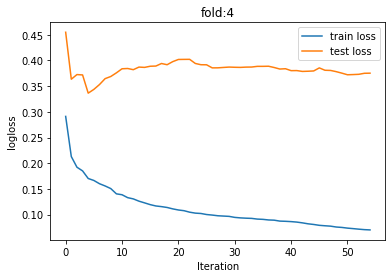

RMSE: [0.3060021768681886, 0.1031734898537942, 0.10749593802589563, 0.01946861960634616, 0.33641321670672764]
RMSE: 0.17451068821219046


In [9]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result_opt2 = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物
    
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)

    best_params = study.best_params

    add_params = {
        'objective':'regression', 
        'metric': 'rmse', 
        'task': 'train', 
        'seed': SEED
        }

    best_params.update(add_params)

    print(best_params)

    model = lgb.train(
                    params=best_params,               # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_opt2.append(rmse)

print("RMSE:", cv_result_opt2)
print("RMSE:", np.mean(cv_result_opt2))

In [10]:
print("RMSE:", round(np.mean(cv_result), 3))
print("Optuna によるハイパラ調整 1 RMSE:", round(np.mean(cv_result_opt), 3))
print("Optuna によるハイパラ調整 2 RMSE:", round(np.mean(cv_result_opt2), 3))

RMSE: 0.199
Optuna によるハイパラ調整 1 RMSE: 0.182
Optuna によるハイパラ調整 2 RMSE: 0.175
